In [ ]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (24.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and direc

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# Seaborn 설정
sns.set_theme(style='whitegrid')

# 📌 나눔고딕 적용
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 확인
print('폰트 적용 완료:', plt.rcParams['font.family'])

폰트 적용 완료: ['NanumGothic']


In [ ]:
!pip install lightgbm -q

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.7 MB/s eta 0:00:00


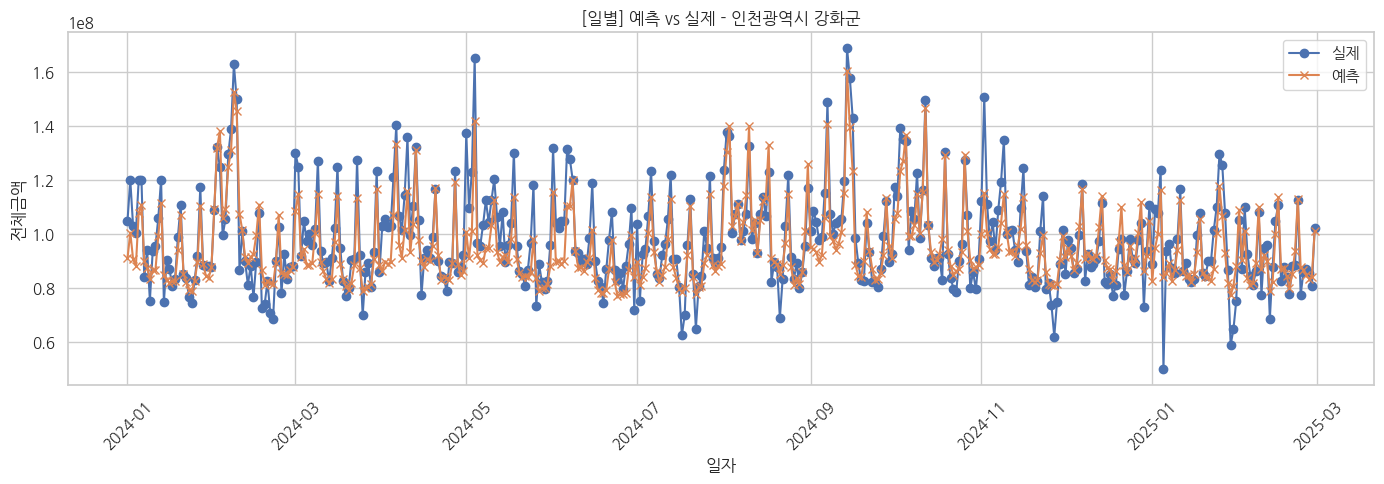

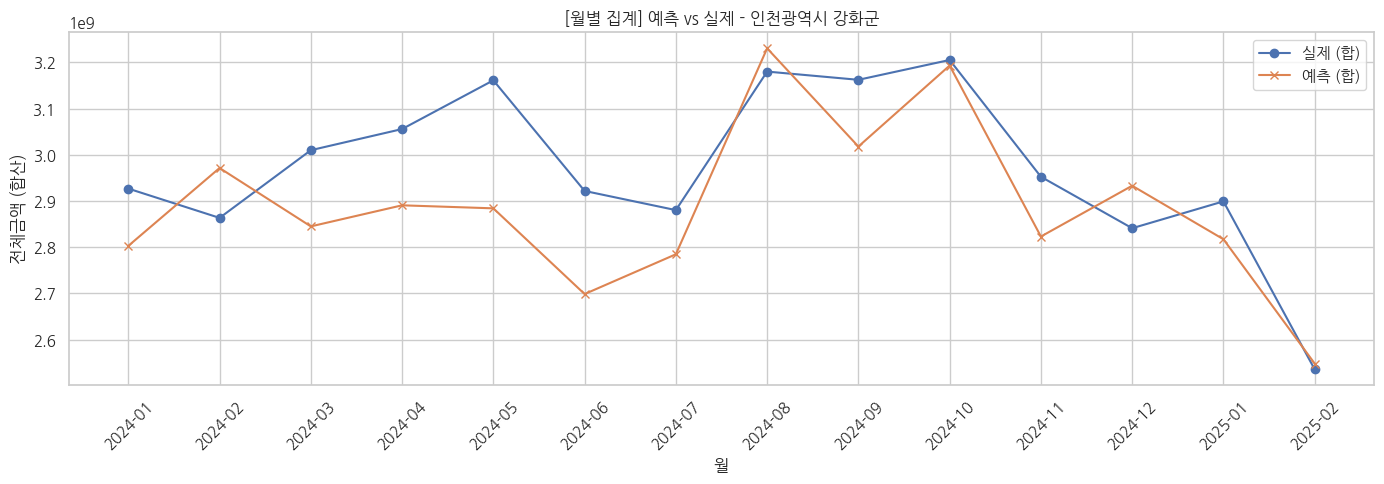

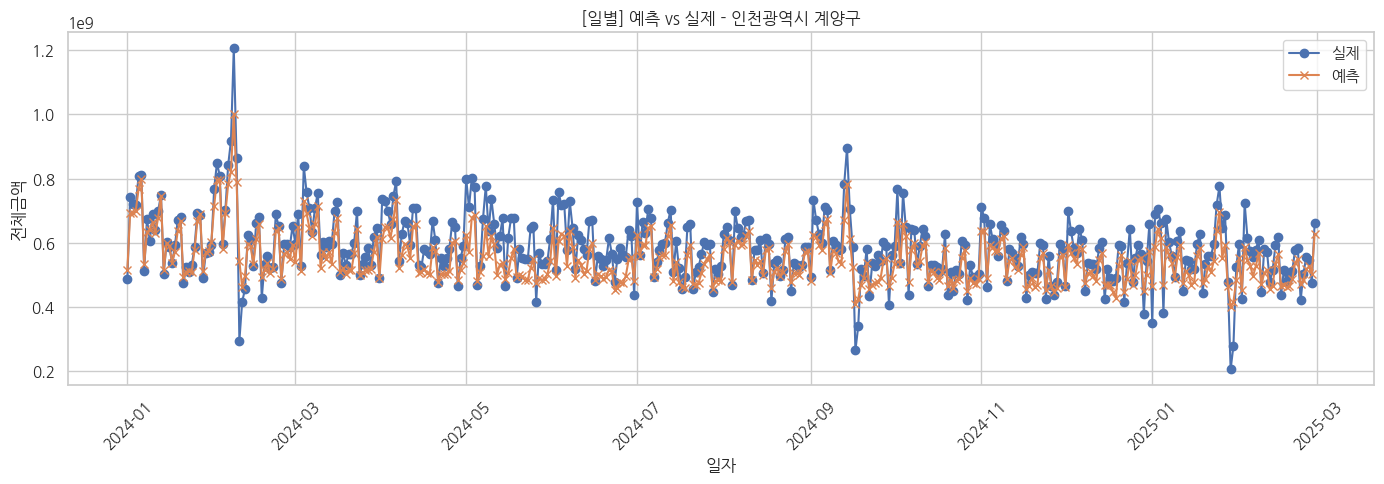

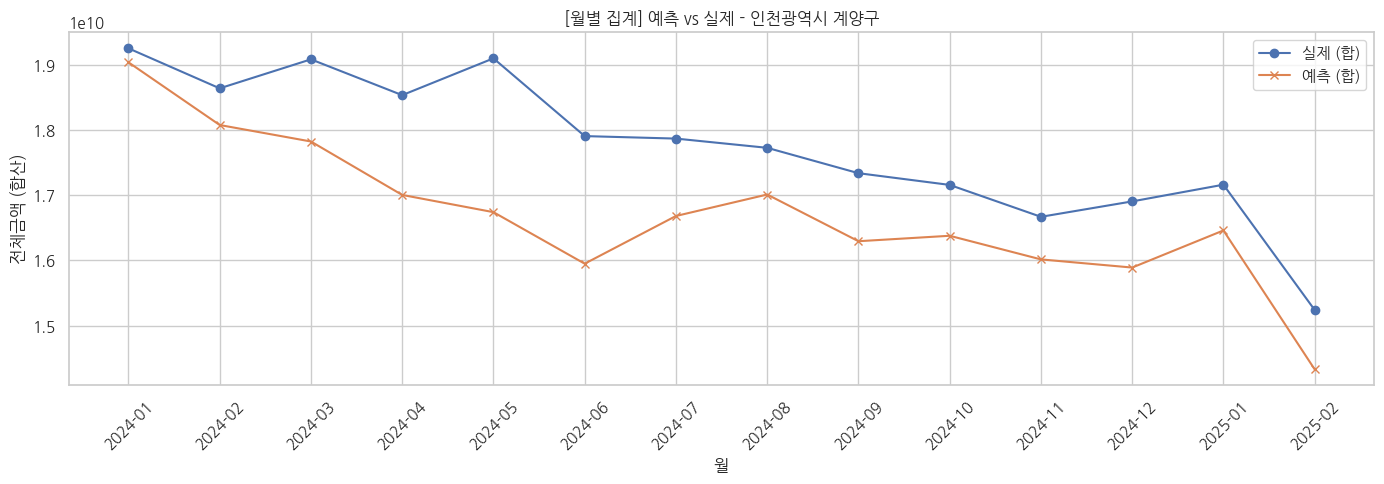

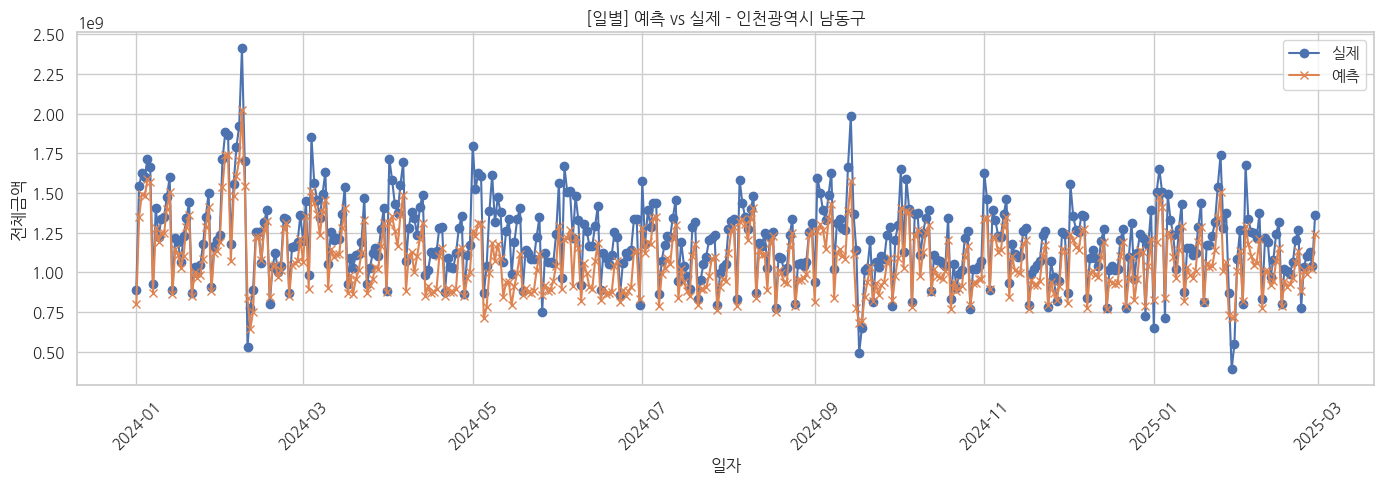

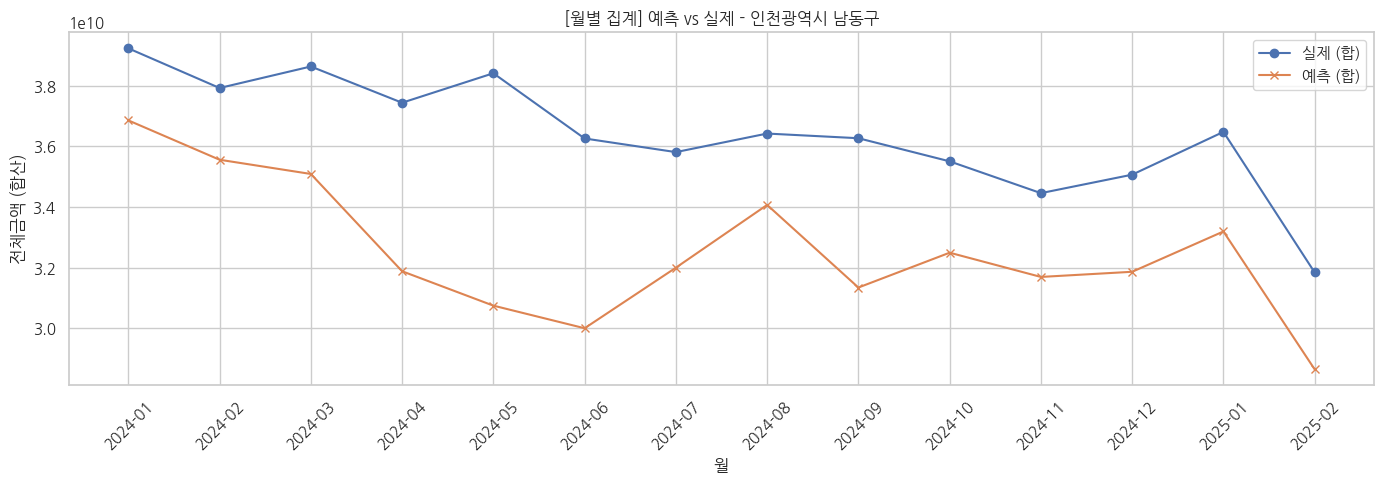

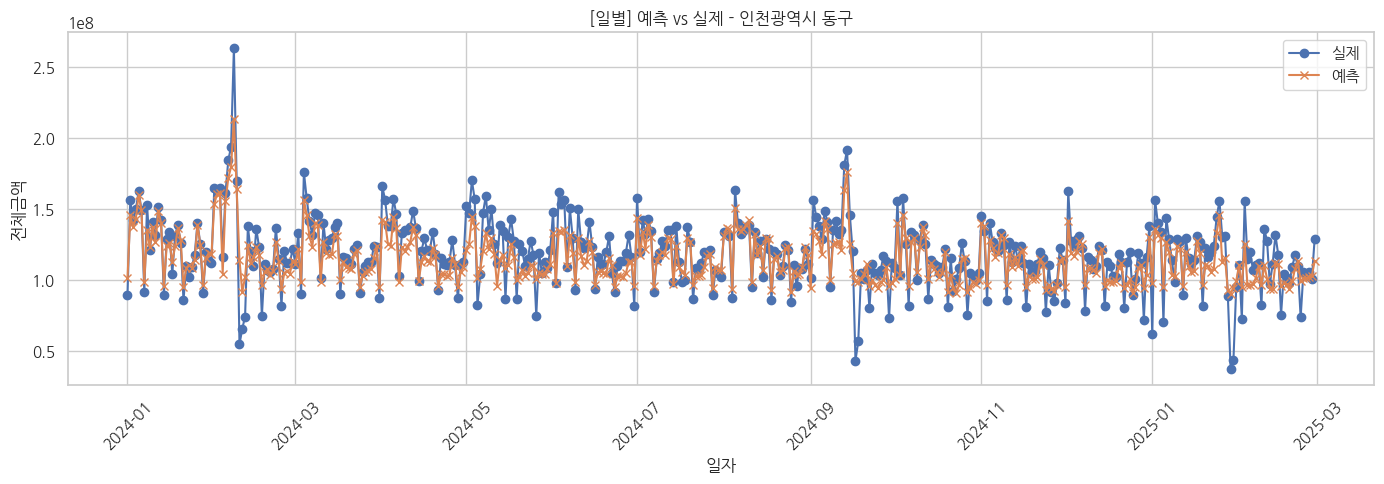

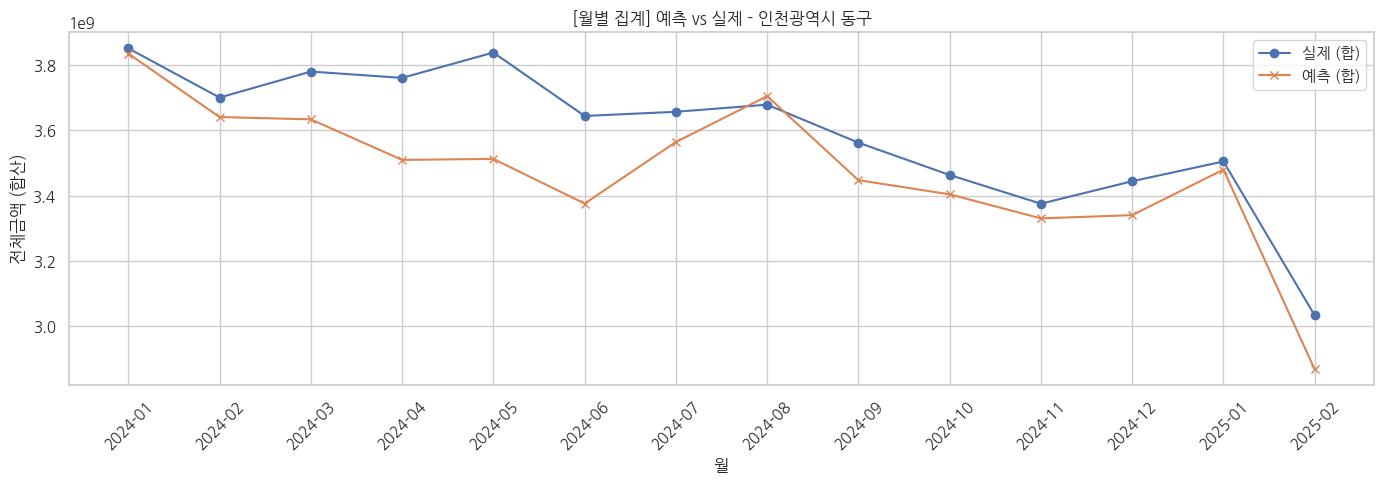

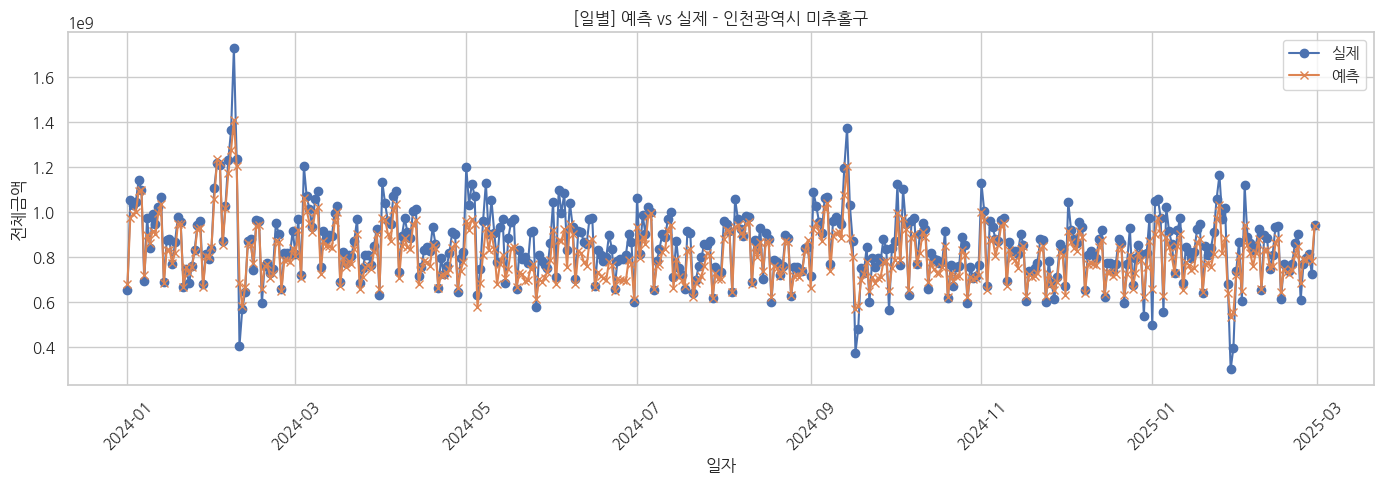

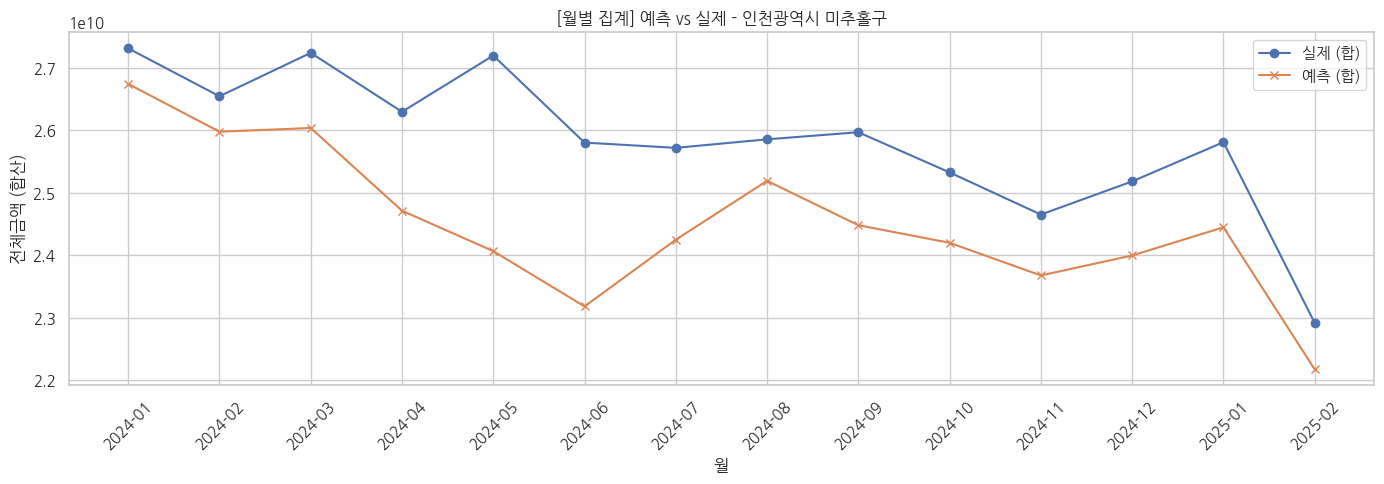

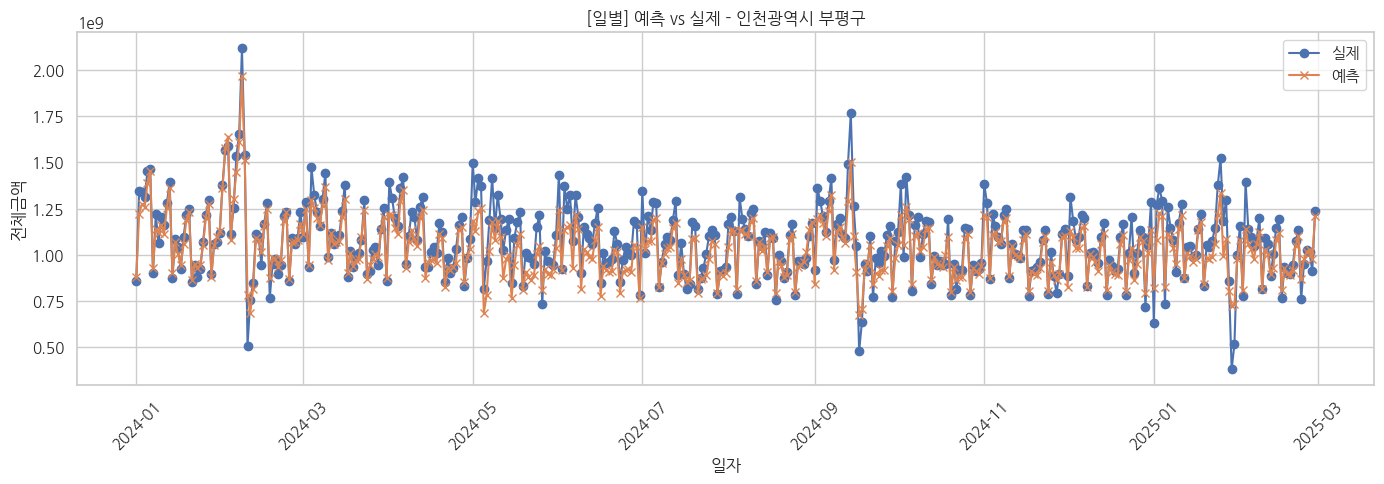

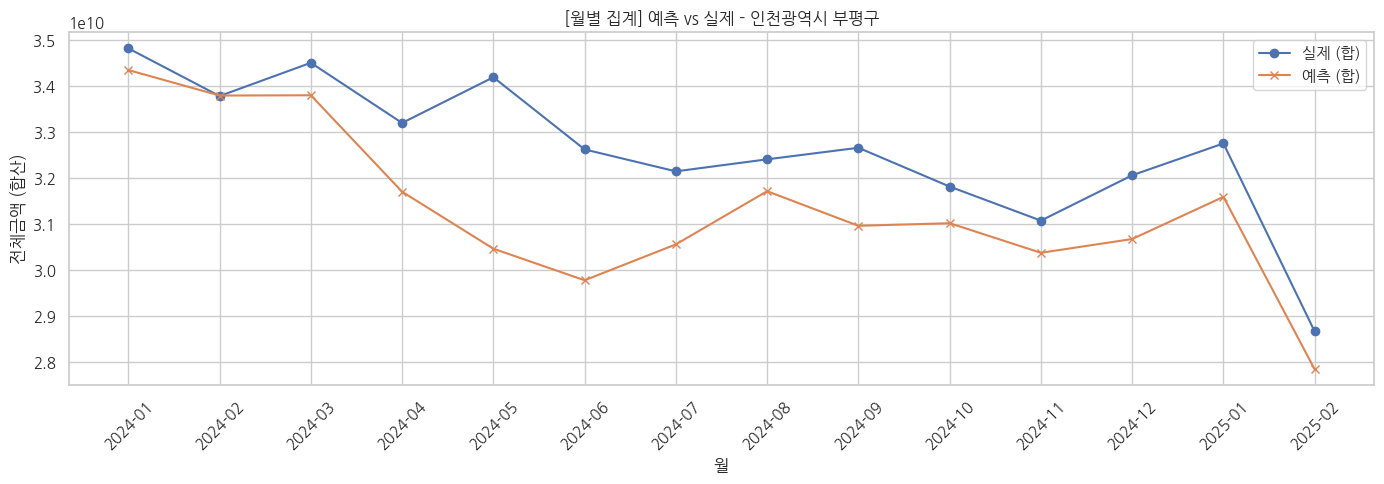

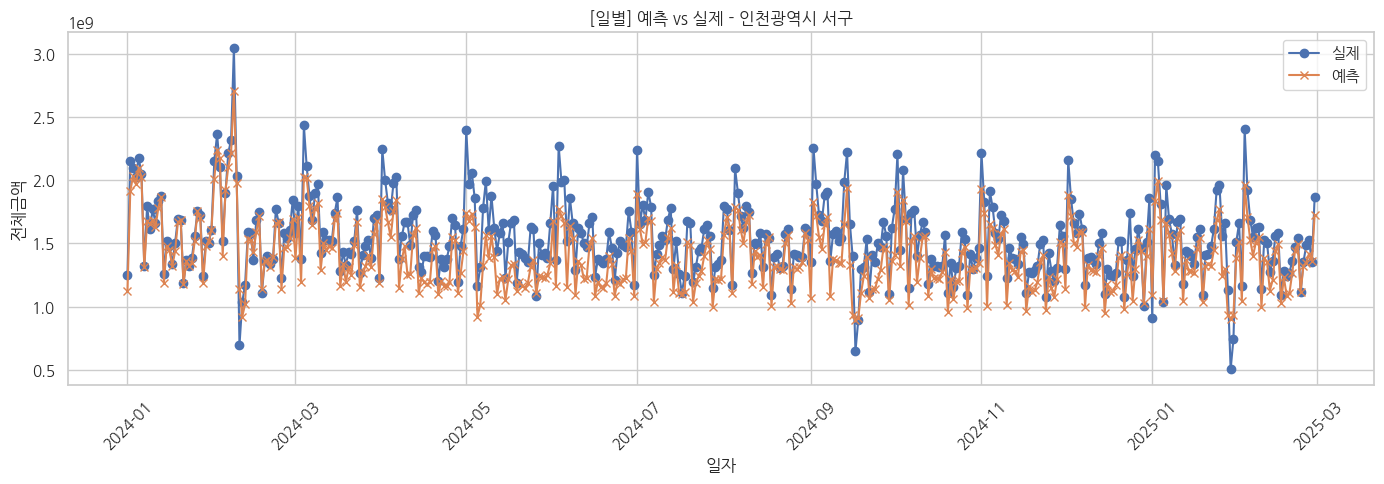

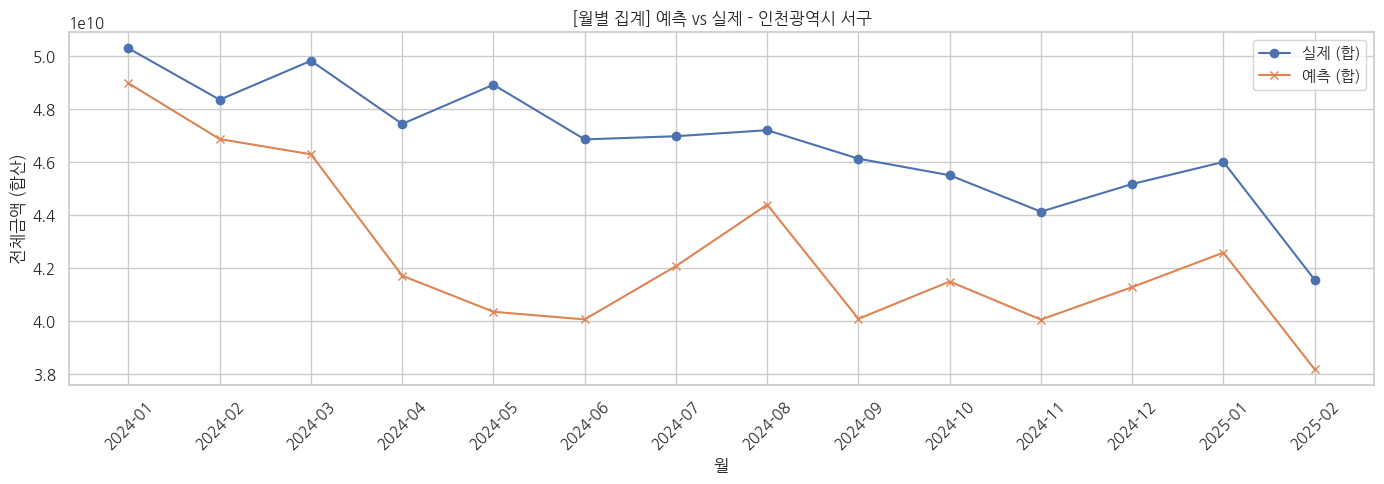

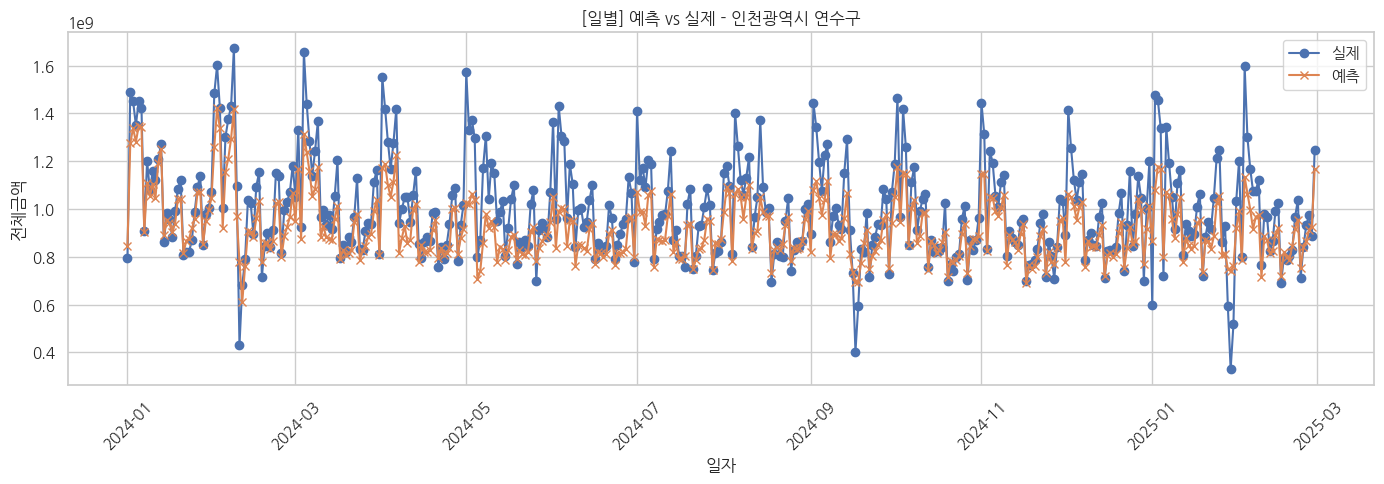

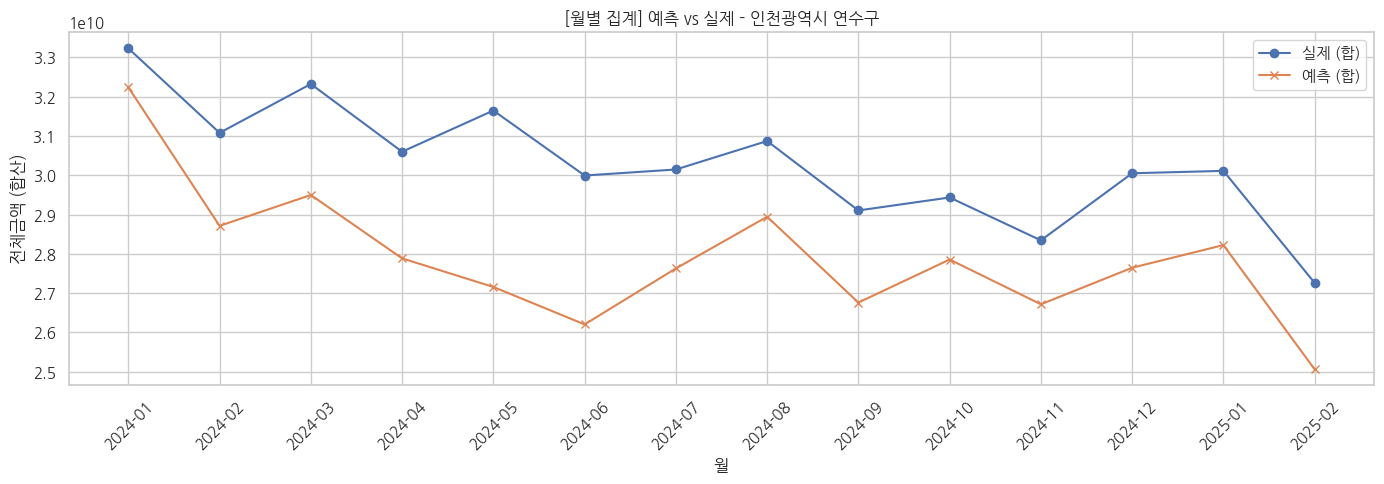

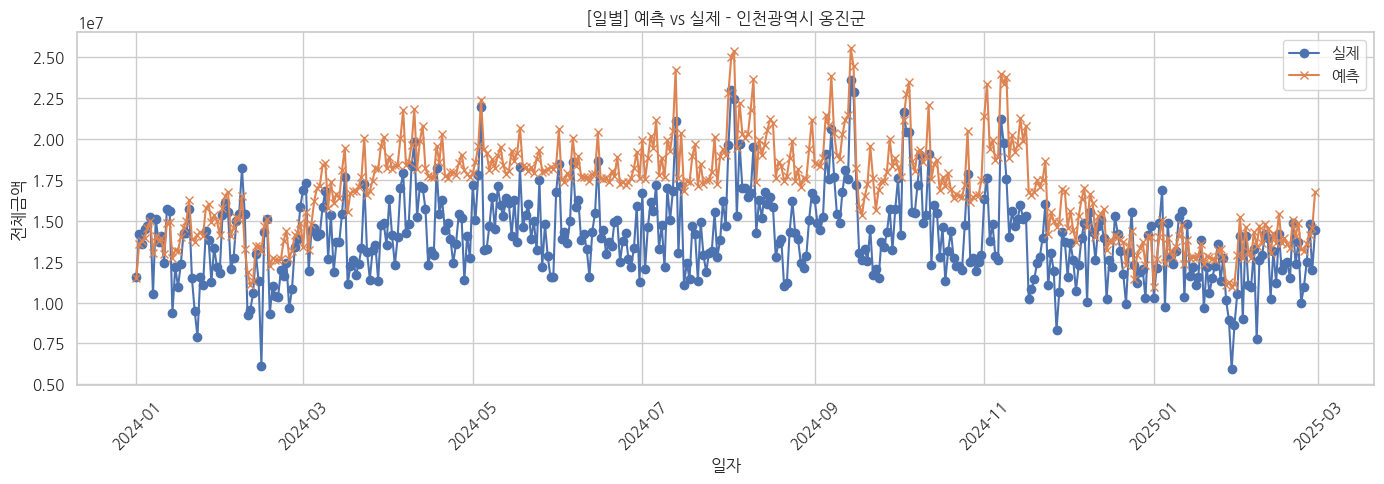

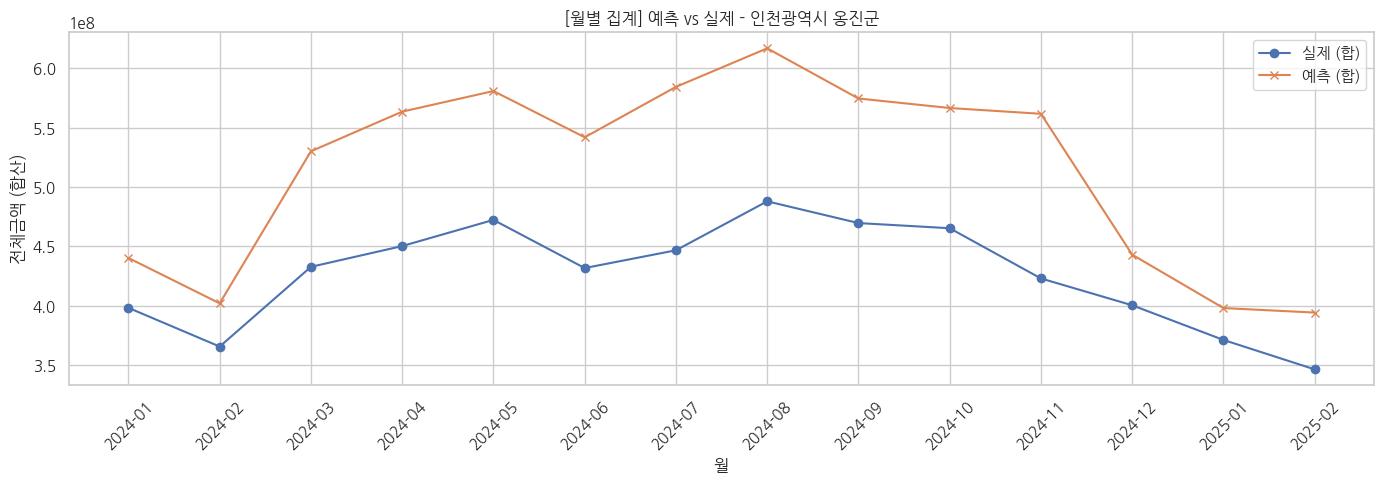

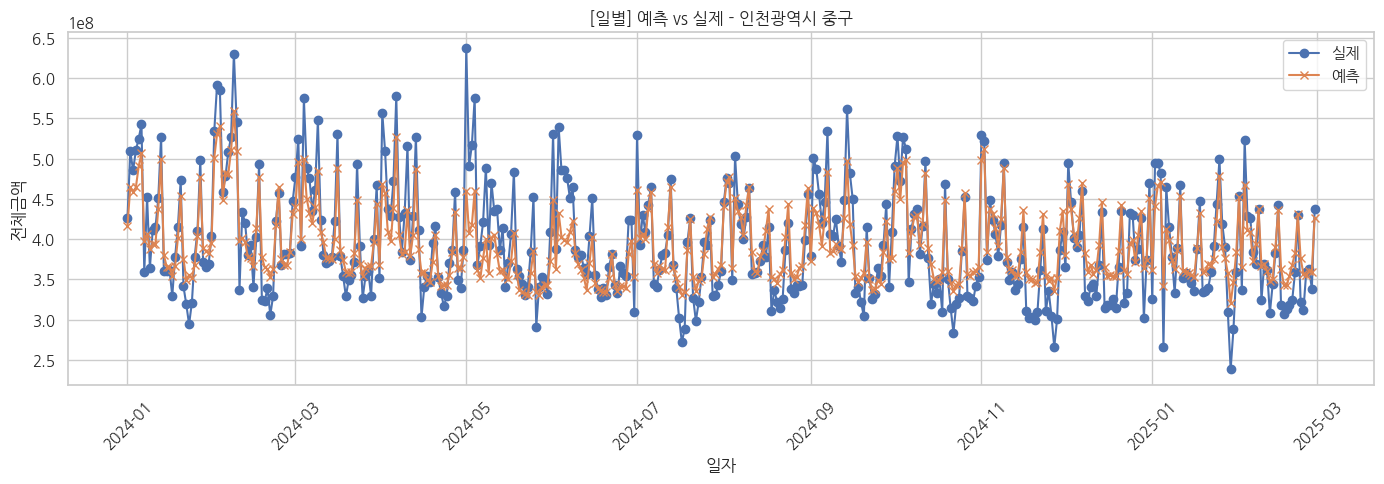

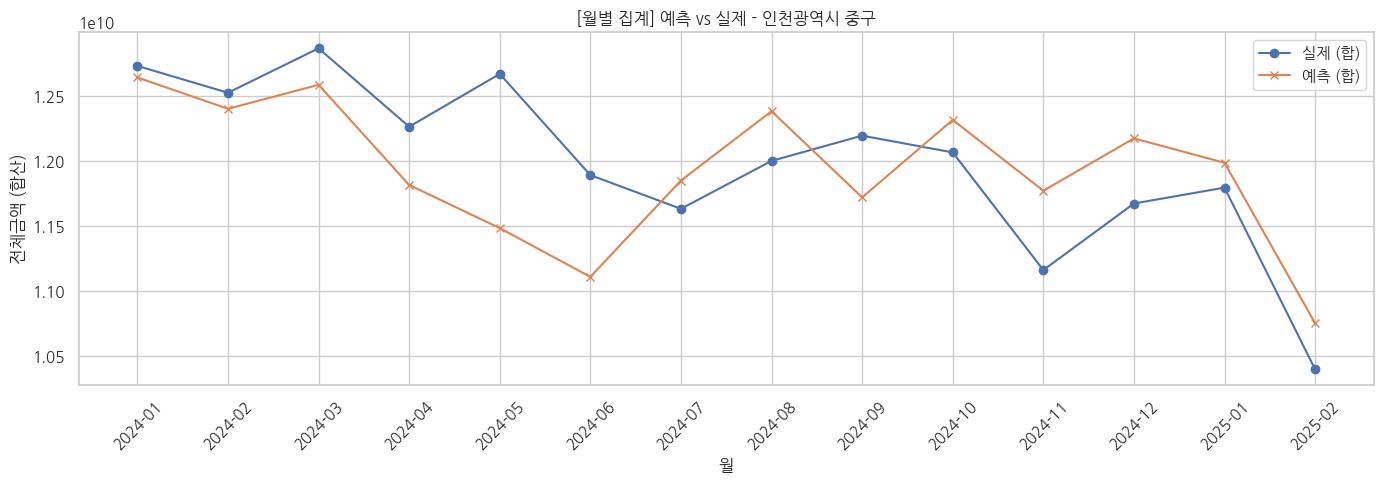

✅ 지역별 MAE / RMSE / MAPE (%)
           지역           MAE          RMSE   MAPE (%)
0   인천광역시 강화군  6.515031e+06  8.605094e+06   6.674281
1   인천광역시 계양구  4.602897e+07  5.714291e+07   8.014952
2   인천광역시 남동구  1.363847e+08  1.615992e+08  11.267533
3    인천광역시 동구  9.392201e+06  1.252389e+07   8.988805
4  인천광역시 미추홀구  5.569158e+07  7.162341e+07   6.618207
5   인천광역시 부평구  6.041579e+07  8.193119e+07   5.714056
6    인천광역시 서구  1.496043e+08  1.795510e+08   9.868259
7   인천광역시 연수구  9.558252e+07  1.295380e+08   9.183005
8   인천광역시 옹진군  3.034970e+06  3.466372e+06  22.956053
9    인천광역시 중구  2.521337e+07  3.317505e+07   6.457551

✅ Feature Importance (중요도 순)
                     Feature  Importance
0                   평년_월별_차이       12225
56   금액_deviation_30_shift_1        3605
27         lpf_trend_shift_1        3179
3                  month_sin        2811
83  금액_deviation_30_shift_28        2380
..                       ...         ...
52        lpf_trend_shift_26         142
38        lpf_trend_shift_12   

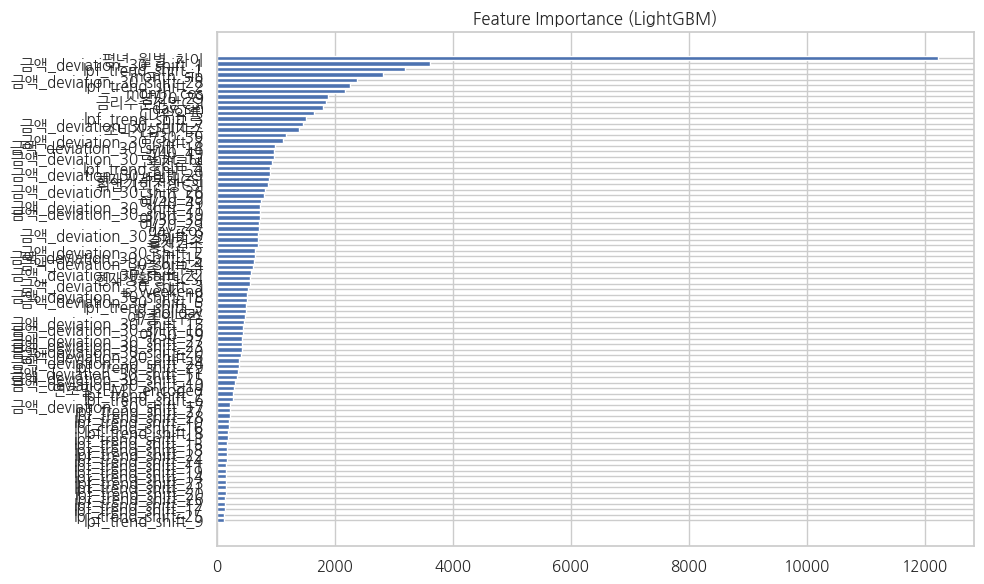

In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 데이터 불러오기 및 정렬
df = pd.read_csv("인천e음_통합_일별.csv", parse_dates=["일자"])
df = df.sort_values(['지역', '일자'])
df["월"] = df["일자"].dt.to_period("M").astype(str)

# 업종별 결제금액 비중 파생 변수 생성
업종_컬럼 = [
    "문화_취미_영화관", "숙박", "약국", "연료",
    "유통업영리_편의점", "일반휴게음식", "학원", "기타"
]
for col in 업종_컬럼:
    df[f"{col}_비중"] = np.where(
        df["전체금액"] != 0,
        df[col] / df["전체금액"],
        0
    )

# 단기 추세: 하루 전
# df["lpf_trend_shift1"] = df.groupby("지역")["lpf_trend"].shift(1)

# 중기 추세: 7일 평균
# df["lpf_trend_rolling7"] = (
#     df.groupby("지역")["lpf_trend"].shift(1).rolling(window=7).mean().reset_index(0, drop=True)
# )

# 장기 추세: 30일 평균 (선택)
# df["lpf_trend_rolling30"] = (
#     df.groupby("지역")["lpf_trend"].shift(1).rolling(window=30).mean().reset_index(0, drop=True)
# )

for lag in range(1, 30):  # 1일부터 29일까지
    df[f"lpf_trend_shift_{lag}"] = df.groupby("지역")["lpf_trend"].shift(lag)

for lag in range(1, 30):  # 1일부터 29일까지
    df[f"금액_deviation_30_shift_{lag}"] = df.groupby("지역")["금액_deviation_30"].shift(lag)

# for lag in range(1, 14):  # 1일부터 13일까지
#     df[f"평년_월별_차_{lag}"] = df.groupby("지역")["평년_월별_차이"].shift(lag)

# 2024년 기준 분할
df_train = df[df["일자"] < "2024-01-01"]
df_val = df[df["일자"] >= "2024-01-01"]

# 특성 및 타겟 설정
features = [
    # "문화_취미_영화관", "숙박", "약국", "연료", "유통업영리_편의점", "일반휴게음식", "학원",
    # "기타",
    # "캐시백_상향", "캐시백_하향", "캐시백_유지개월", "캐시백_변동_소비변화율",
    # "lpf_trend",
    # "금액_deviation_30",
    "평년_월별_차이",
    # "lpf_trend_shift1",
    # "lpf_trend_rolling7",
    # "lpf_trend_rolling30",
    "is_weekend", "is_holiday", "month_sin", "month_cos", "day_sin", "day_cos",
    "연초말_EMT_encoded",
    # "가계부채전망CSI", "가계수입전망CSI", "가계저축전망CSI", "물가수준전망CSI",
    # "생활형편전망CSI", "소비지출전망CSI", "임금수준전망CSI", "주택가격전망CSI",
    # "향후경기전망CSI", "현재가계저축CSI", "현재경기판단CSI",
    "소비자심리지수", "CD수익률", "금리수준전망CSI", "현재생활형편CSI", "취업기회전망CSI", "현재가계부채CSI",
    "남/20_29", "남/30_39", "남/40_49", "남/50_59", "남/총인구수", "여/20_29", "여/30_39", "여/40_49", "여/50_59", "여/총인구수",
    # "남/0_9", "남/100 +", "남/10_19", "남/60_69",
    # "남/70_79", "남/80_89", "남/90_99", "남/총인구수",
    # "여/0_9", "여/100 +", "여/10_19", "여/60_69",
    # "여/70_79", "여/80_89", "여/90_99", "여/총인구수",
    "충전건수", "충전금액", "결제건수"
]
target = "전체금액"

features += [f"lpf_trend_shift_{lag}" for lag in range(1, 30)]
features += [f"금액_deviation_30_shift_{lag}" for lag in range(1, 30)]
# features += [f"평년_월별_차_{lag}" for lag in range(1, 14)]


# Global LightGBM 모델 학습
X_train = df_train[features]
y_train = df_train[target]
X_val = df_val[features]

model = lgb.LGBMRegressor(
    n_estimators=879,
    learning_rate=0.006593162865614713,
    num_leaves=215,
    max_depth=10,
    min_child_samples=92,
    subsample=0.7186900301226251,
    colsample_bytree=0.5586715762310078,
    reg_alpha=1.377046983677005e-07,
    reg_lambda=1.8694568958308537e-08,
    random_state=42
)
model.fit(X_train, y_train)

# 예측 및 결합
y_pred = model.predict(X_val)
df_val_eval = df_val.copy()
df_val_eval["예측값"] = y_pred

# 지역별 성능 평가 및 시각화
regions = df_val_eval["지역"].unique()
performance_rows = []

for region in regions:
    df_region = df_val_eval[df_val_eval["지역"] == region].copy()

    # 성능 계산
    mae = mean_absolute_error(df_region["전체금액"], df_region["예측값"])
    rmse = np.sqrt(mean_squared_error(df_region["전체금액"], df_region["예측값"]))

    # MAPE 계산 (0 나누기 방지)
    valid_idx = df_region["전체금액"] != 0
    if valid_idx.sum() > 0:
        mape = np.mean(
            np.abs(
                (df_region.loc[valid_idx, "전체금액"] - df_region.loc[valid_idx, "예측값"])
                / df_region.loc[valid_idx, "전체금액"]
            )
        ) * 100
    else:
        mape = np.nan

    performance_rows.append({
        "지역": region,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

    # 1. 일일 예측 시각화
    plt.figure(figsize=(14, 5))
    plt.plot(df_region["일자"], df_region["전체금액"], label="실제", marker='o')
    plt.plot(df_region["일자"], df_region["예측값"], label="예측", marker='x')
    plt.title(f"[일별] 예측 vs 실제 - {region}")
    plt.xlabel("일자")
    plt.ylabel("전체금액")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. 월별 집계 및 시각화
    df_month = df_region.groupby("월")[["전체금액", "예측값"]].sum().reset_index()
    plt.figure(figsize=(14, 5))
    plt.plot(df_month["월"], df_month["전체금액"], label="실제 (합)", marker='o')
    plt.plot(df_month["월"], df_month["예측값"], label="예측 (합)", marker='x')
    plt.title(f"[월별 집계] 예측 vs 실제 - {region}")
    plt.xlabel("월")
    plt.ylabel("전체금액 (합산)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 전체 성능 결과 표 출력
df_performance = pd.DataFrame(performance_rows)
print("지역별 MAE / RMSE / MAPE (%)")
print(df_performance)


# 모델 학습 이후에 feature importance 추출 추가
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 중요도 출력
print("\nFeature Importance (중요도 순)")
print(feature_importance_df)

# 시각화 (선택사항)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (LightGBM)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import optuna

# 데이터 로드
df = pd.read_csv("인천e음_통합_일별.csv", parse_dates=["일자"])
df = df.sort_values(['지역', '일자'])
df["월"] = df["일자"].dt.to_period("M").astype(str)

# 업종별 결제금액 비중 파생 변수 생성
업종_컬럼 = [
    "문화_취미_영화관", "숙박", "약국", "연료",
    "유통업영리_편의점", "일반휴게음식", "학원", "기타"
]
for col in 업종_컬럼:
    df[f"{col}_비중"] = np.where(
        df["전체금액"] != 0,
        df[col] / df["전체금액"],
        0
    )

# 시차 변수 생성
for lag in range(1, 30):
    df[f"lpf_trend_shift_{lag}"] = df.groupby("지역")["lpf_trend"].shift(lag)
    df[f"금액_deviation_30_shift_{lag}"] = df.groupby("지역")["금액_deviation_30"].shift(lag)

# 데이터 분할
df_train = df[df["일자"] < "2024-01-01"]
df_val = df[df["일자"] >= "2024-01-01"]

# 특성과 타겟
features = [
    "평년_월별_차이", "is_weekend", "is_holiday", "month_sin", "month_cos",
    "day_sin", "day_cos", "연초말_EMT_encoded", "소비자심리지수", "CD수익률",
    "금리수준전망CSI", "현재생활형편CSI", "취업기회전망CSI", "현재가계부채CSI",
    "남/20_29", "남/30_39", "남/40_49", "남/50_59", "남/총인구수",
    "여/20_29", "여/30_39", "여/40_49", "여/50_59", "여/총인구수",
    "충전건수", "충전금액", "결제건수"
]
features += [f"lpf_trend_shift_{lag}" for lag in range(1, 30)]
features += [f"금액_deviation_30_shift_{lag}" for lag in range(1, 30)]
target = "전체금액"

X_train = df_train[features]
y_train = df_train[target]
X_val = df_val[features]
y_val = df_val[target]

# Optuna 목적 함수
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return mean_absolute_error(y_val, preds)

# Optuna 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# 최적 파라미터 확인
study.best_trial.params


[I 2025-05-17 04:36:02,640] A new study created in memory with name: no-name-71cd3e2f-a50e-486b-ac43-6ba98e7082c0
[I 2025-05-17 04:36:13,654] Trial 0 finished with value: 74159752.54645215 and parameters: {'n_estimators': 554, 'learning_rate': 0.03792422190685348, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 74, 'subsample': 0.6699250425555412, 'colsample_bytree': 0.9189695943906003, 'reg_alpha': 3.769406495765319e-05, 'reg_lambda': 0.0045038094105408055}. Best is trial 0 with value: 74159752.54645215.
[I 2025-05-17 04:36:30,397] Trial 1 finished with value: 72036885.95026909 and parameters: {'n_estimators': 722, 'learning_rate': 0.13812378736187736, 'num_leaves': 288, 'max_depth': 11, 'min_child_samples': 38, 'subsample': 0.9304527053032763, 'colsample_bytree': 0.9451708101125142, 'reg_alpha': 0.18137323361861268, 'reg_lambda': 0.027024301628189393}. Best is trial 1 with value: 72036885.95026909.
[I 2025-05-17 04:37:14,878] Trial 2 finished with value: 152305538.0657446 and 

{'n_estimators': 879,
 'learning_rate': 0.006593162865614713,
 'num_leaves': 215,
 'max_depth': 10,
 'min_child_samples': 92,
 'subsample': 0.7186900301226251,
 'colsample_bytree': 0.5586715762310078,
 'reg_alpha': 1.377046983677005e-07,
 'reg_lambda': 1.8694568958308537e-08}

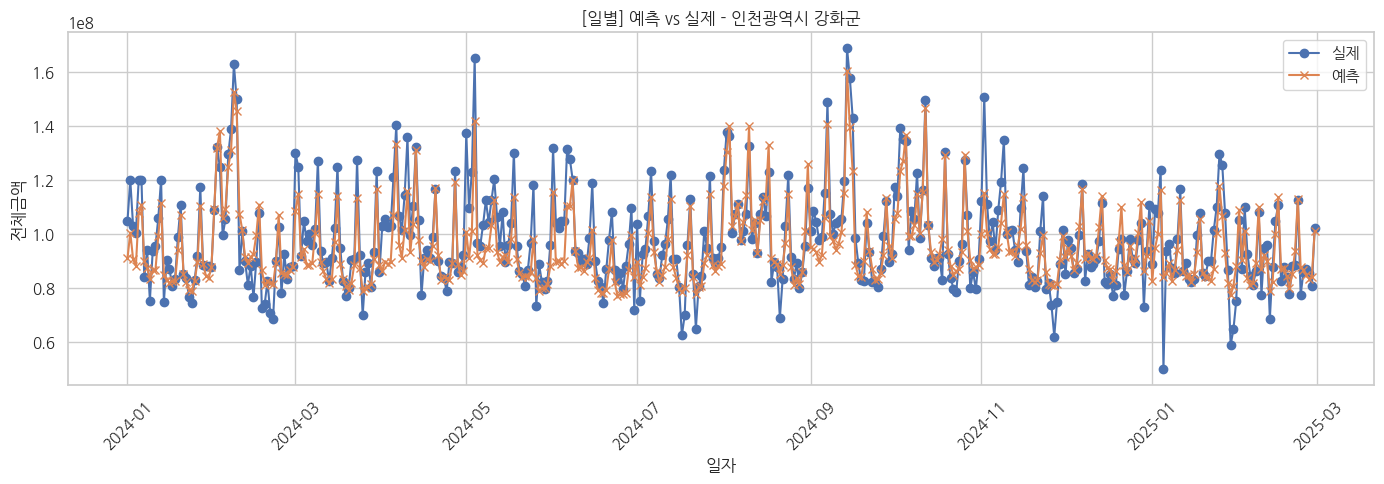

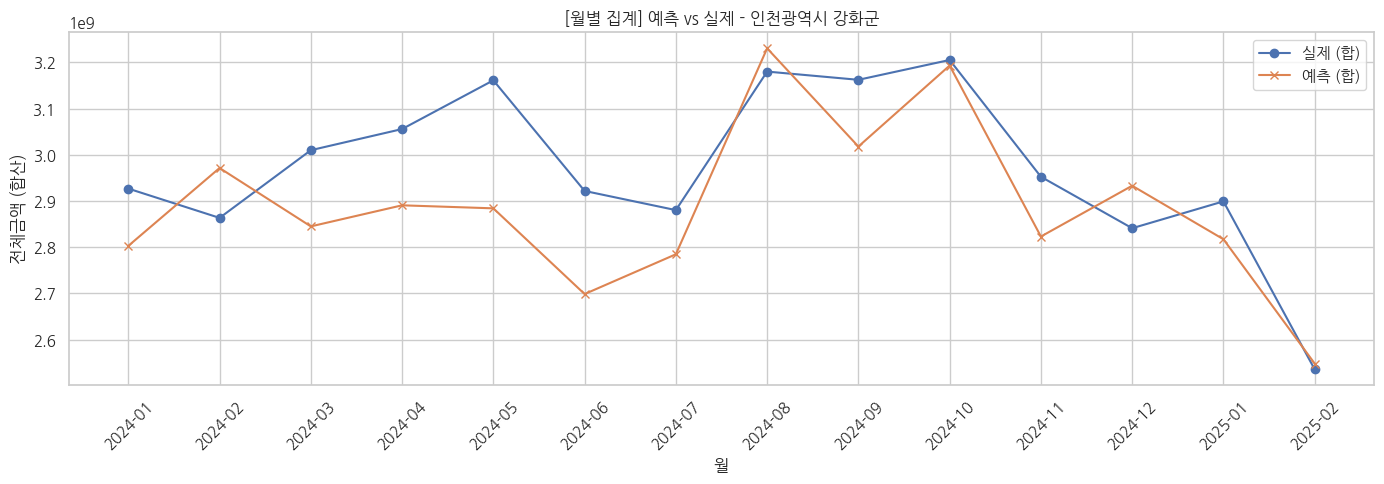

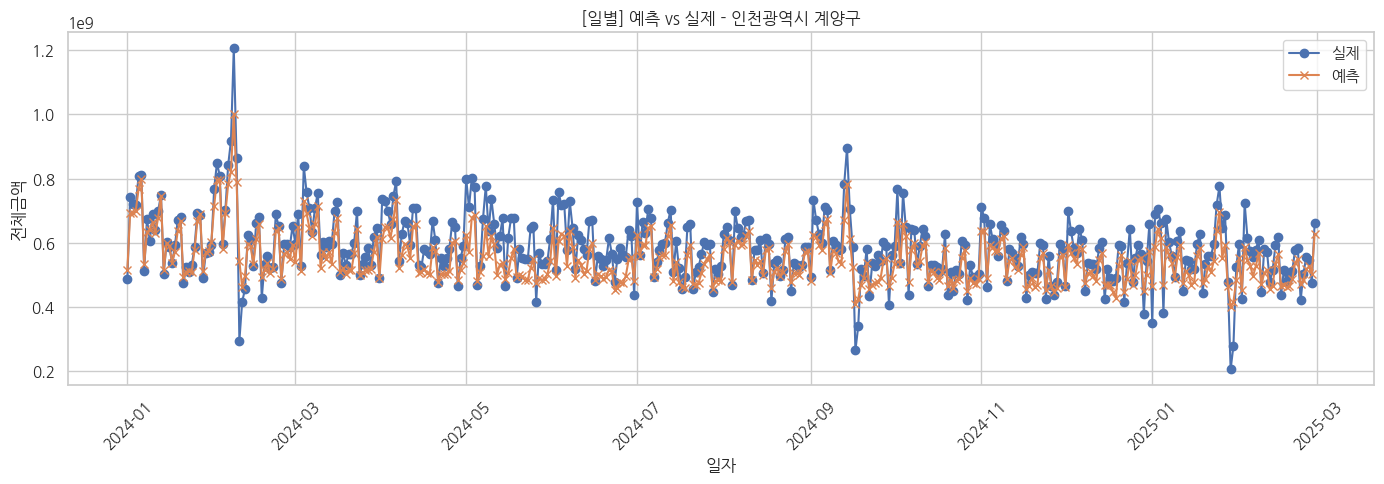

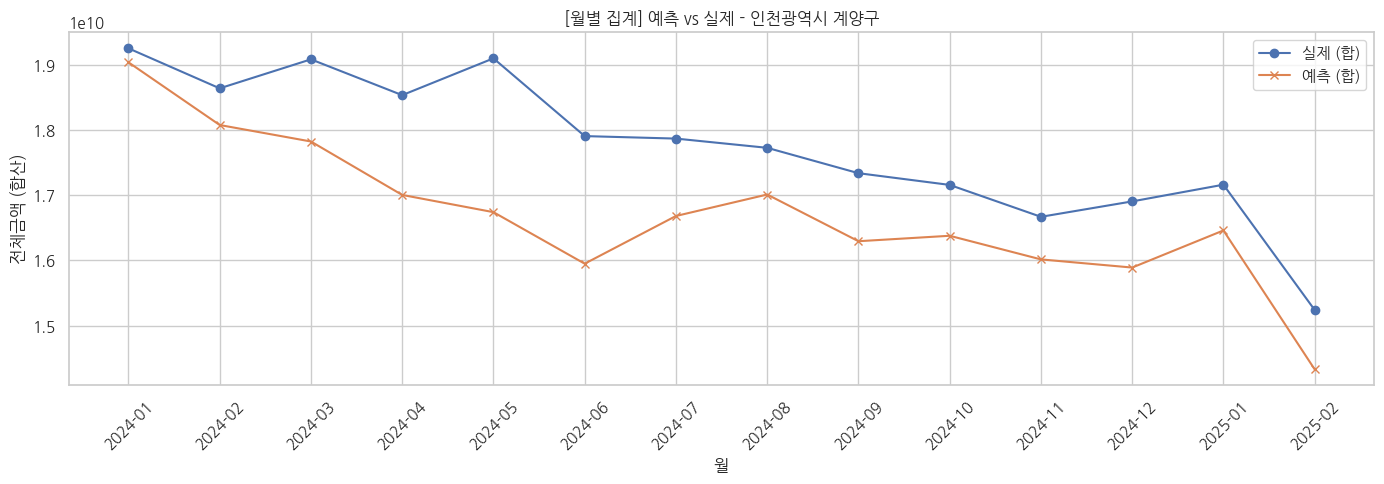

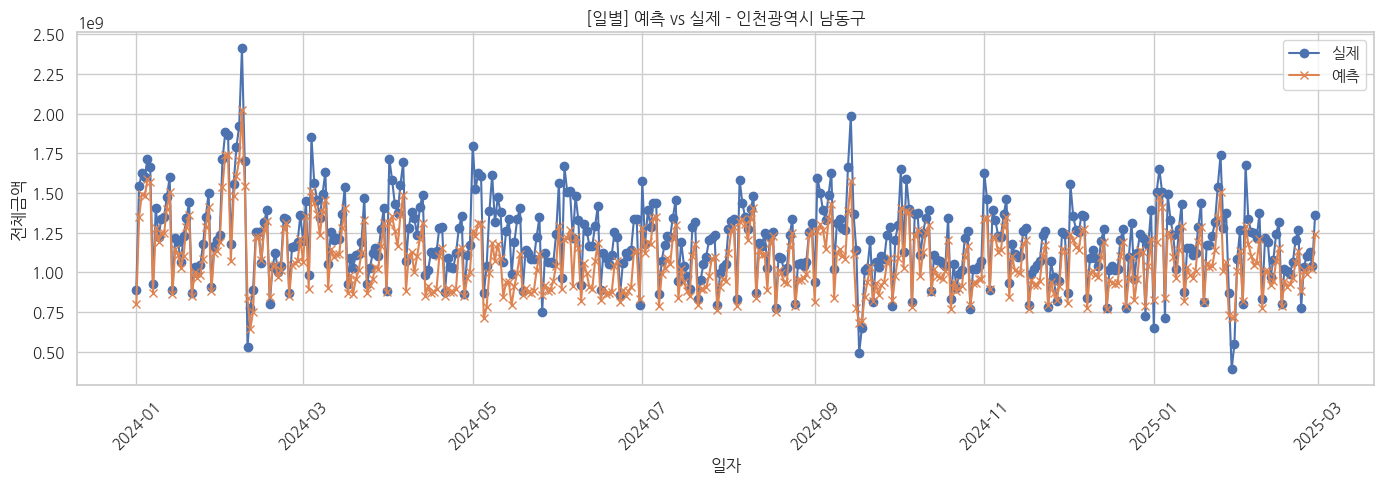

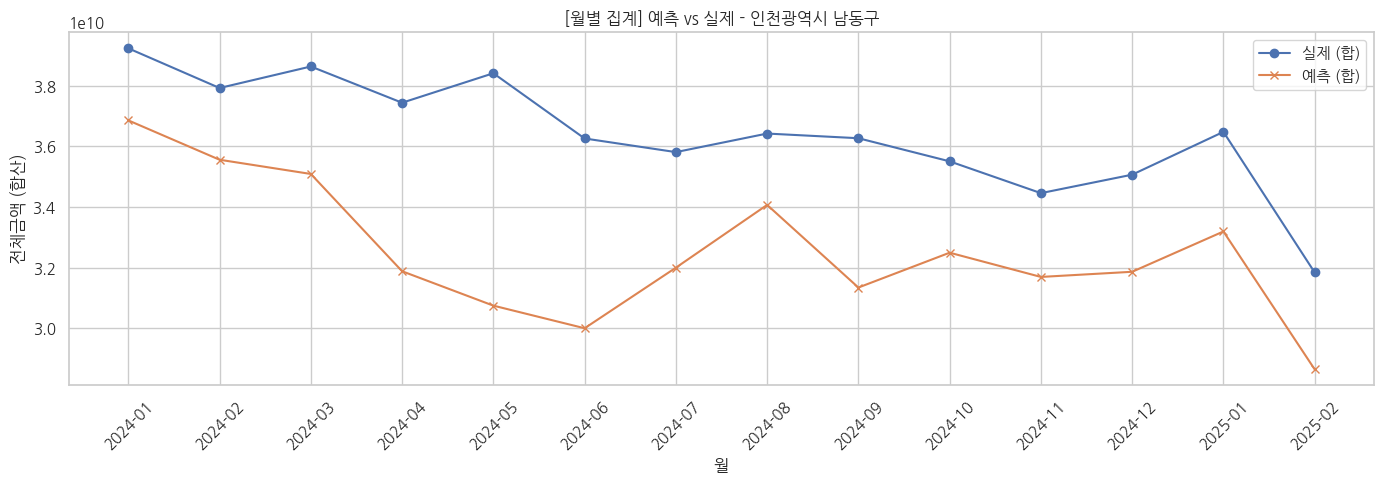

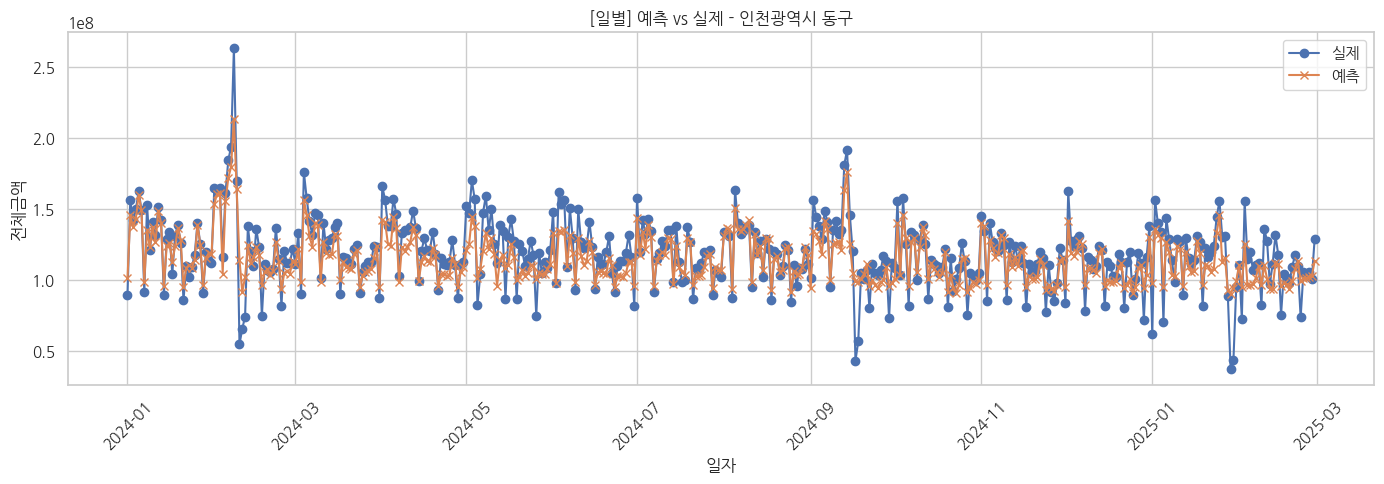

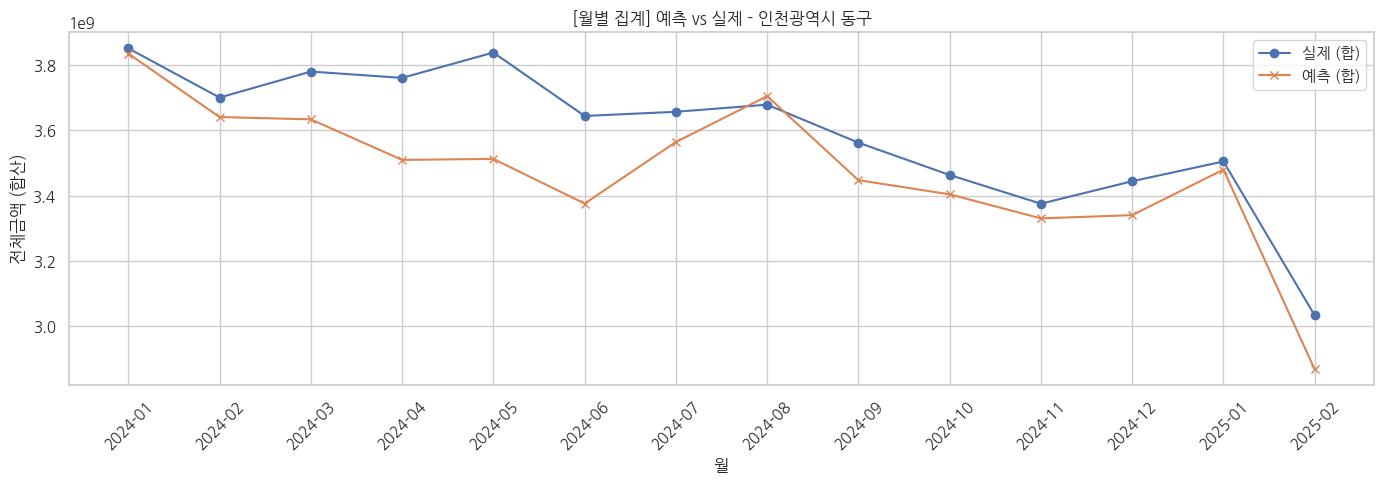

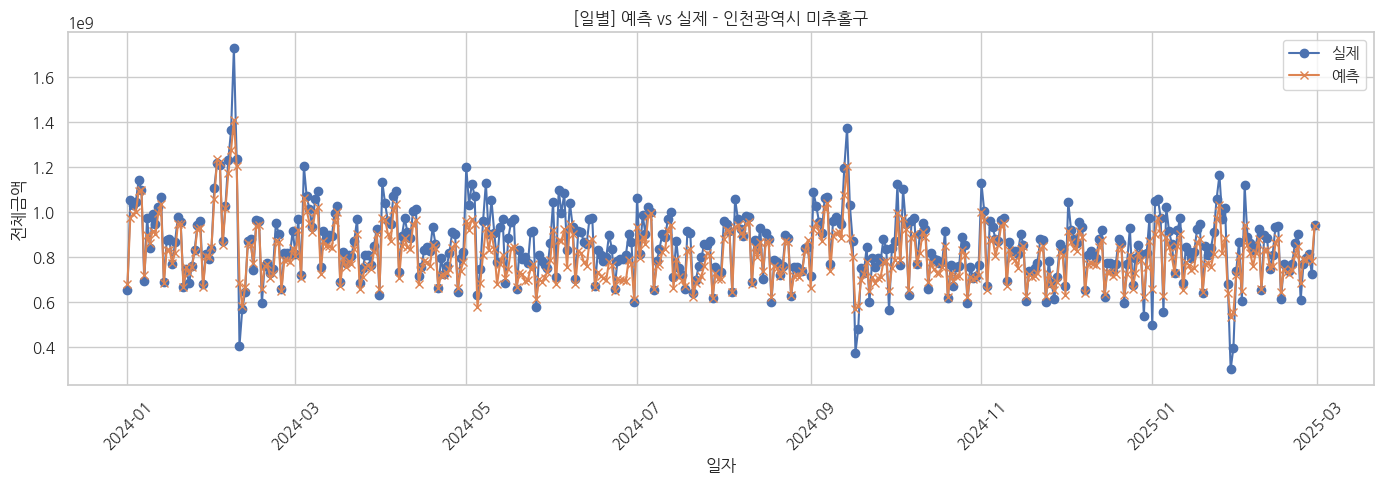

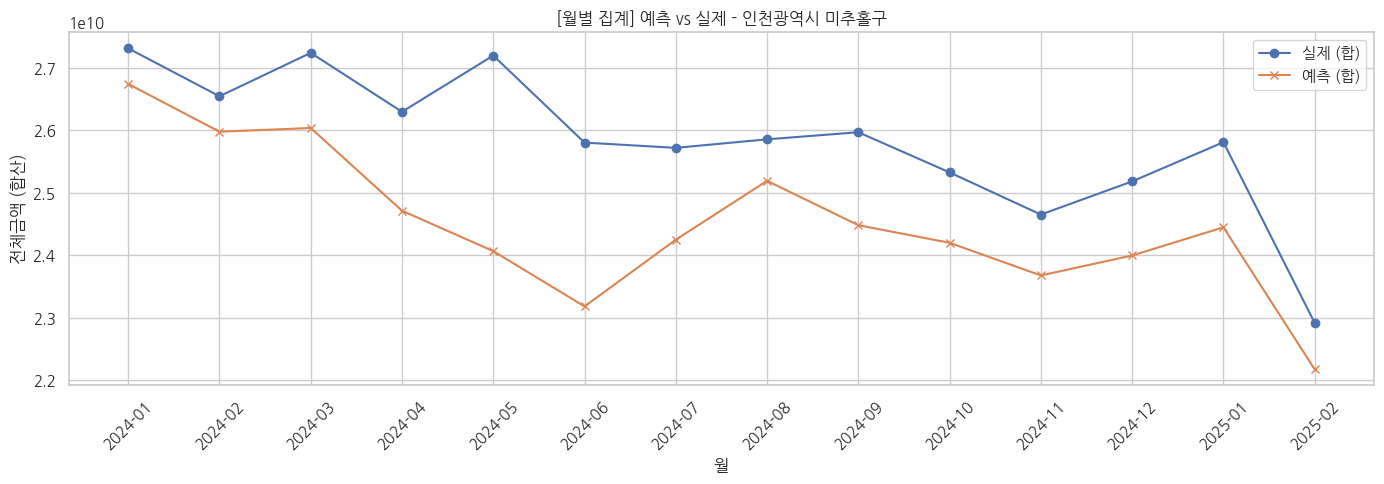

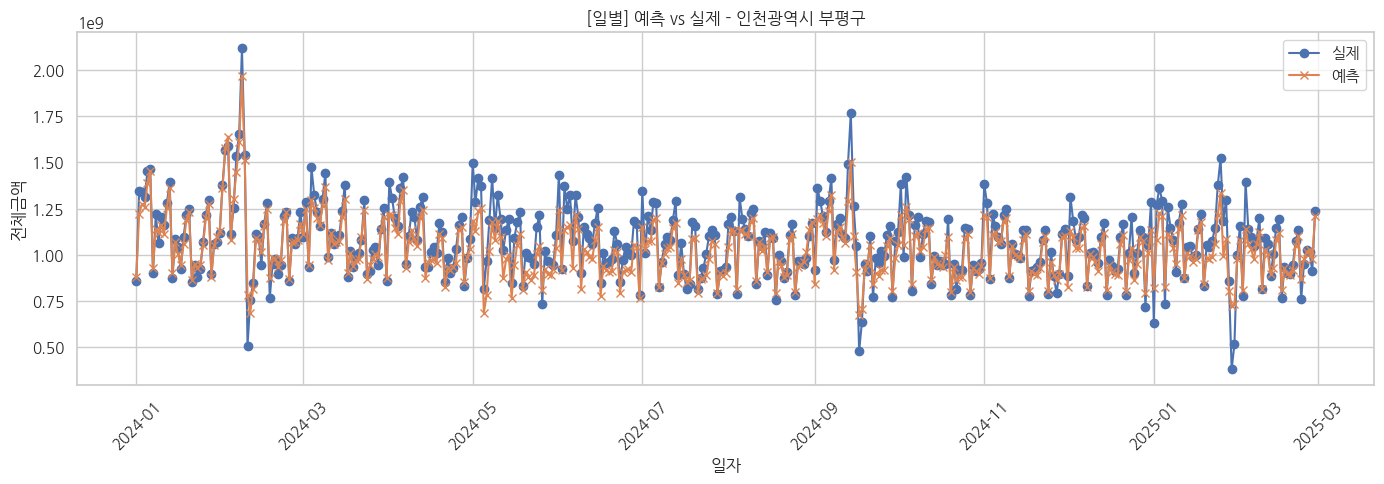

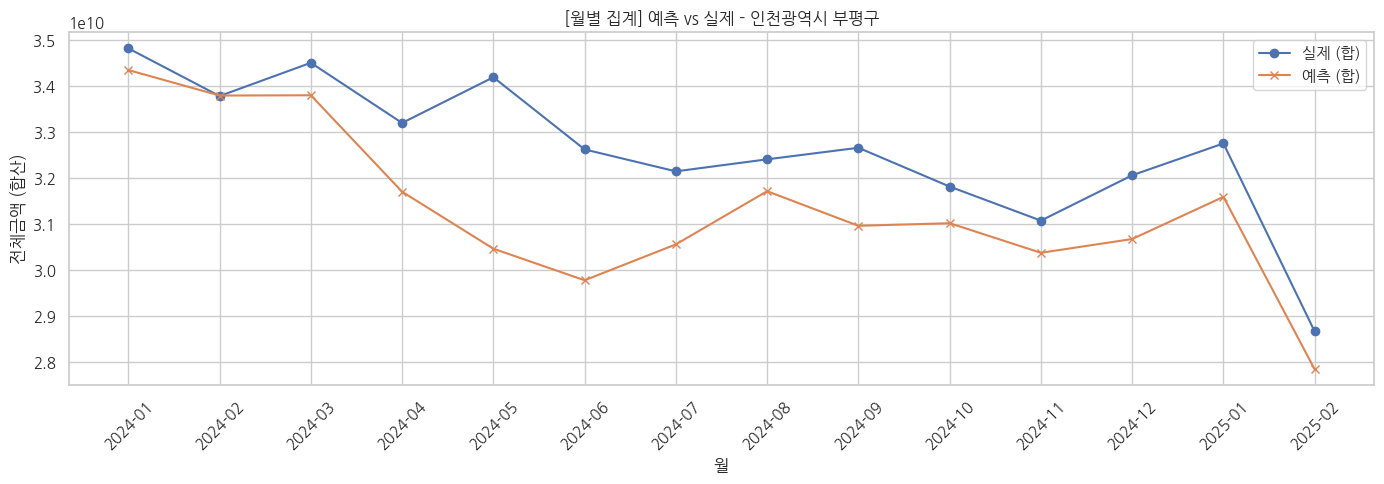

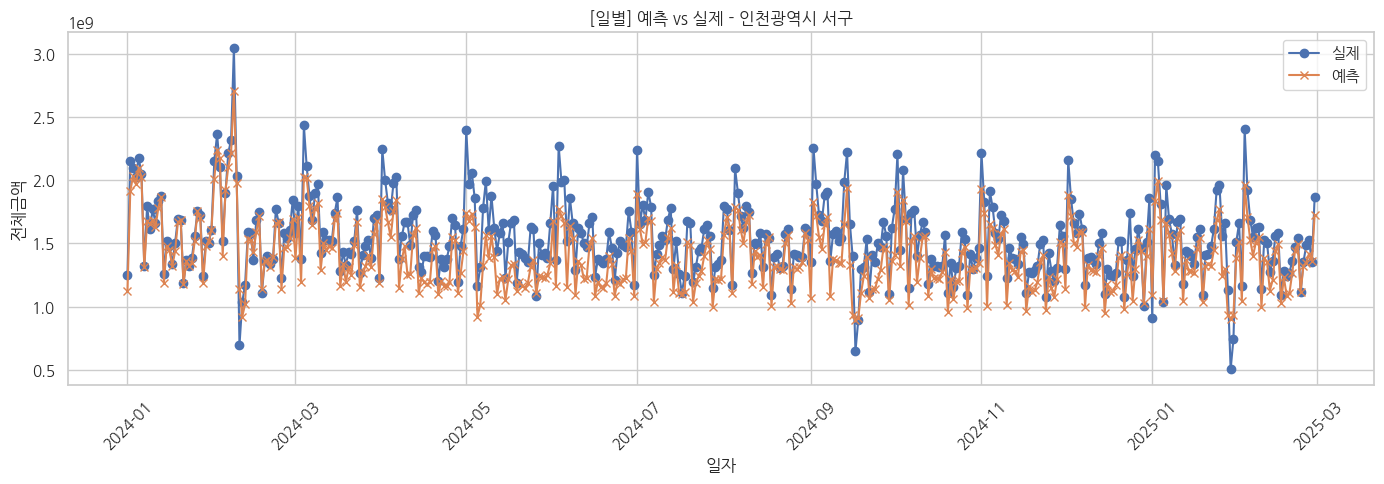

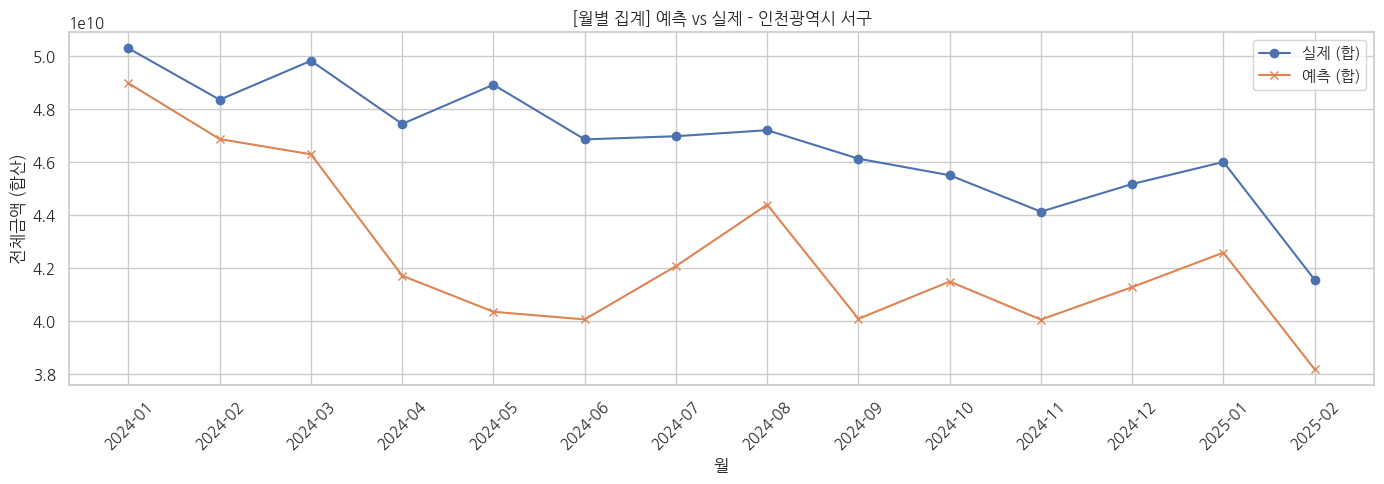

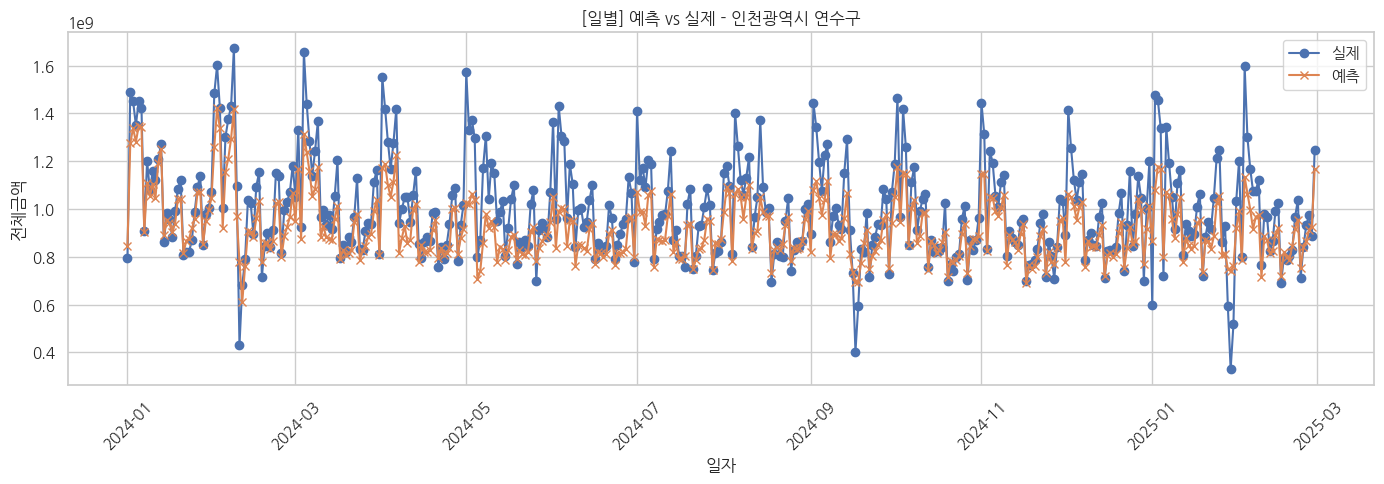

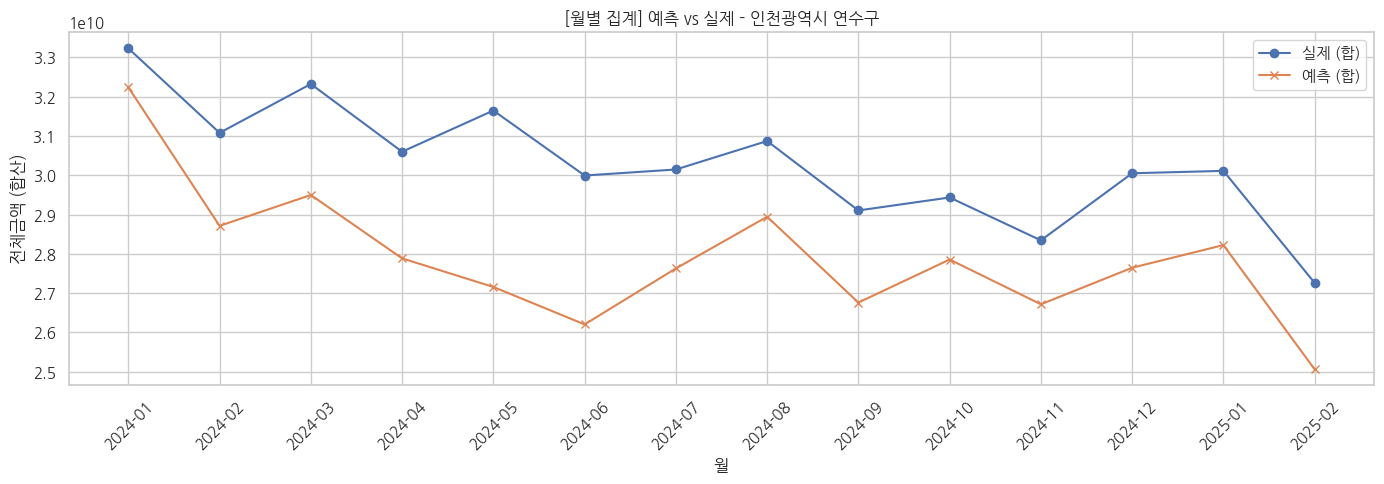

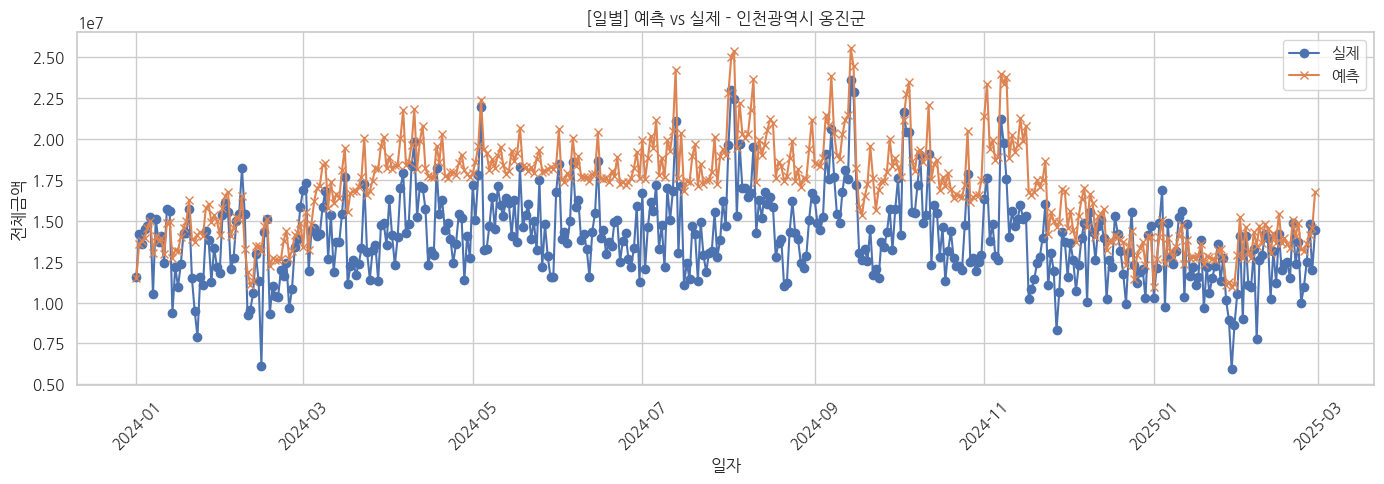

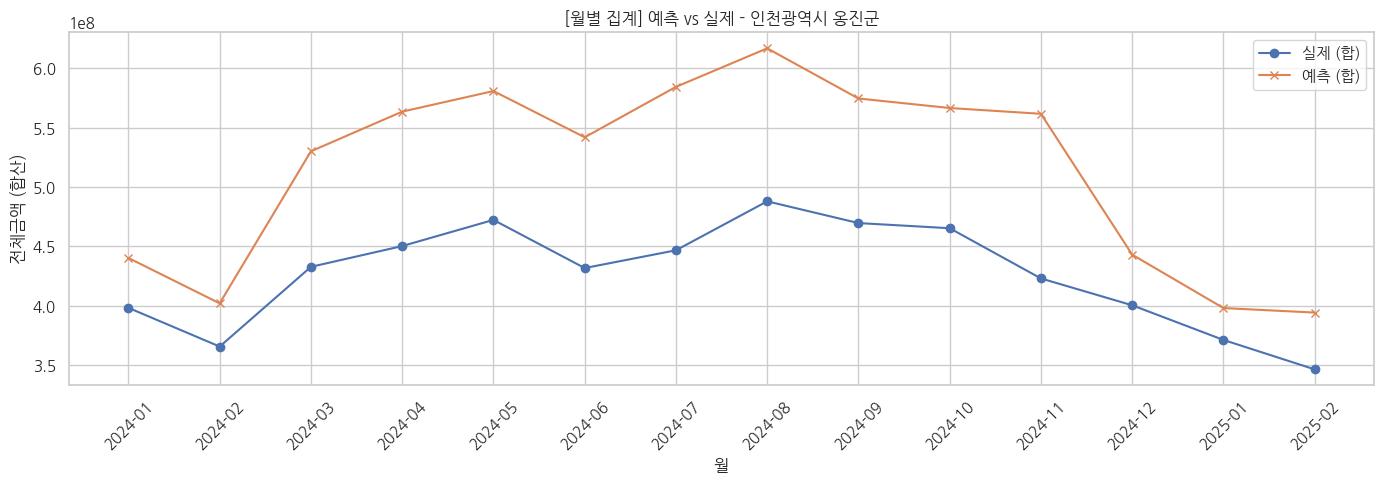

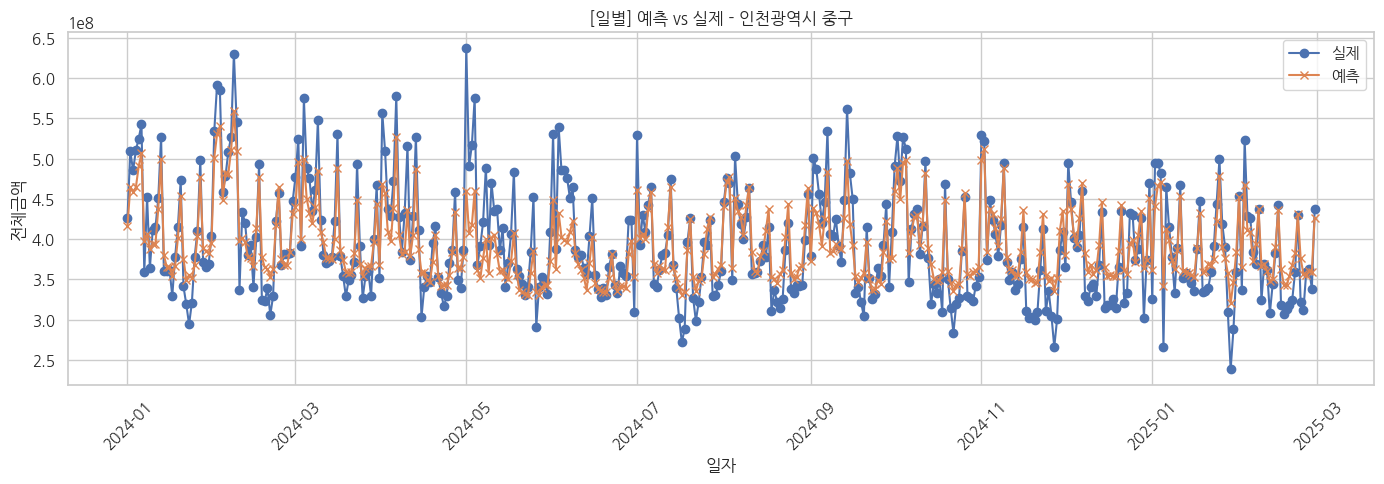

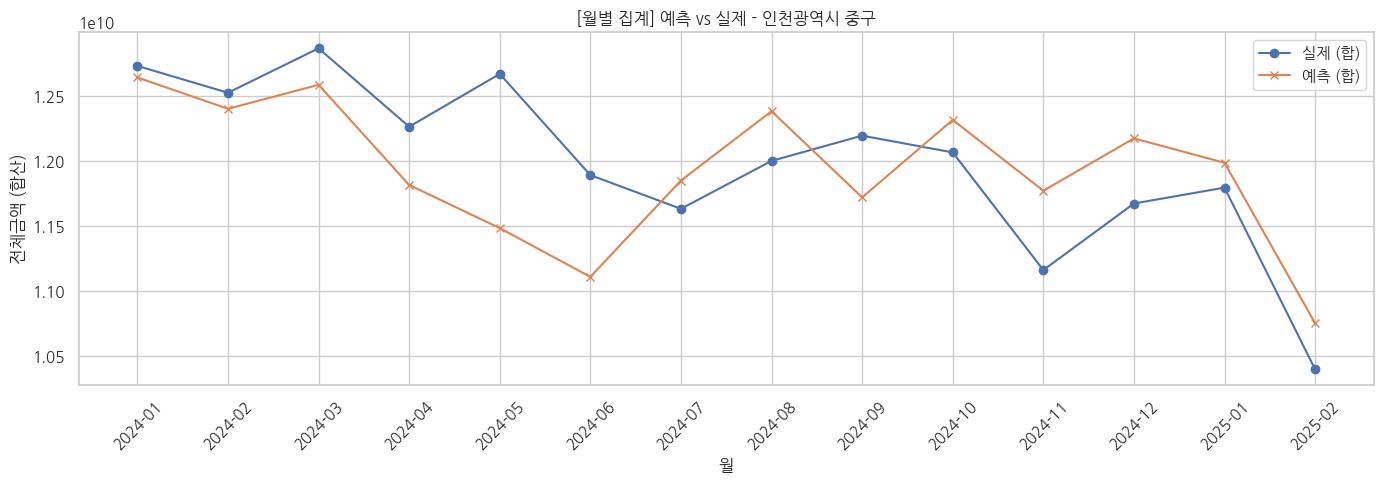

✅ 지역별 MAE / RMSE / MAPE (%)
           지역           MAE          RMSE   MAPE (%)
0   인천광역시 강화군  6.515031e+06  8.605094e+06   6.674281
1   인천광역시 계양구  4.602897e+07  5.714291e+07   8.014952
2   인천광역시 남동구  1.363847e+08  1.615992e+08  11.267533
3    인천광역시 동구  9.392201e+06  1.252389e+07   8.988805
4  인천광역시 미추홀구  5.569158e+07  7.162341e+07   6.618207
5   인천광역시 부평구  6.041579e+07  8.193119e+07   5.714056
6    인천광역시 서구  1.496043e+08  1.795510e+08   9.868259
7   인천광역시 연수구  9.558252e+07  1.295380e+08   9.183005
8   인천광역시 옹진군  3.034970e+06  3.466372e+06  22.956053
9    인천광역시 중구  2.521337e+07  3.317505e+07   6.457551

✅ Feature Importance (중요도 순)
                     Feature  Importance
0                   평년_월별_차이       12225
56   금액_deviation_30_shift_1        3605
27         lpf_trend_shift_1        3179
3                  month_sin        2811
83  금액_deviation_30_shift_28        2380
..                       ...         ...
52        lpf_trend_shift_26         142
38        lpf_trend_shift_12   

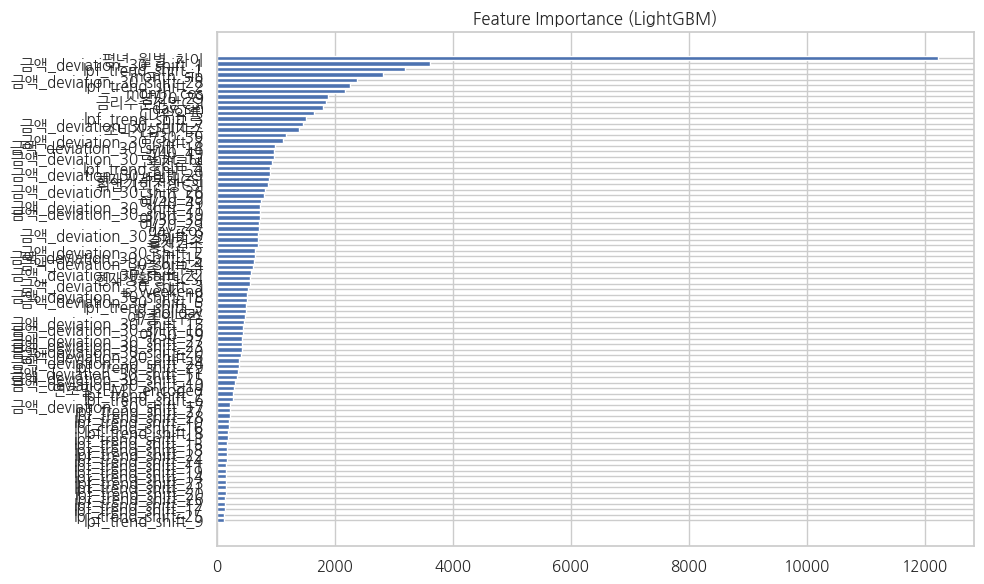

In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 데이터 불러오기 및 정렬
df = pd.read_csv("인천e음_통합_일별.csv", parse_dates=["일자"])
df = df.sort_values(['지역', '일자'])
df["월"] = df["일자"].dt.to_period("M").astype(str)

# 업종별 결제금액 비중 파생 변수 생성
업종_컬럼 = [
    "문화_취미_영화관", "숙박", "약국", "연료",
    "유통업영리_편의점", "일반휴게음식", "학원", "기타"
]
for col in 업종_컬럼:
    df[f"{col}_비중"] = np.where(
        df["전체금액"] != 0,
        df[col] / df["전체금액"],
        0
    )

for lag in range(1, 30):  # 1일부터 29일까지
    df[f"lpf_trend_shift_{lag}"] = df.groupby("지역")["lpf_trend"].shift(lag)

for lag in range(1, 30):  # 1일부터 29일까지
    df[f"금액_deviation_30_shift_{lag}"] = df.groupby("지역")["금액_deviation_30"].shift(lag)

# 2024년 기준 분할
df_train = df[df["일자"] < "2024-01-01"]
df_val = df[df["일자"] >= "2024-01-01"]

# 특성 및 타겟 설정
features = [
    # "문화_취미_영화관", "숙박", "약국", "연료", "유통업영리_편의점", "일반휴게음식", "학원",
    # "기타",
    "평년_월별_차이",
    "is_weekend", "is_holiday", "month_sin", "month_cos", "day_sin", "day_cos",
    "연초말_EMT_encoded",
    "소비자심리지수", "CD수익률", "금리수준전망CSI", "현재생활형편CSI", "취업기회전망CSI", "현재가계부채CSI",
    "남/20_29", "남/30_39", "남/40_49", "남/50_59", "남/총인구수", "여/20_29", "여/30_39", "여/40_49", "여/50_59", "여/총인구수",
    "충전건수", "충전금액", "결제건수"
]
target = "전체금액"

features += [f"lpf_trend_shift_{lag}" for lag in range(1, 30)]
features += [f"금액_deviation_30_shift_{lag}" for lag in range(1, 30)]


# Global LightGBM 모델 학습
X_train = df_train[features]
y_train = df_train[target]
X_val = df_val[features]

model = lgb.LGBMRegressor(
    n_estimators=879,
    learning_rate=0.006593162865614713,
    num_leaves=215,
    max_depth=10,
    min_child_samples=92,
    subsample=0.7186900301226251,
    colsample_bytree=0.5586715762310078,
    reg_alpha=1.377046983677005e-07,
    reg_lambda=1.8694568958308537e-08,
    random_state=42
)
model.fit(X_train, y_train)

# 예측 및 결합
y_pred = model.predict(X_val)
df_val_eval = df_val.copy()
df_val_eval["예측값"] = y_pred

# 지역별 성능 평가 및 시각화
regions = df_val_eval["지역"].unique()
performance_rows = []

for region in regions:
    df_region = df_val_eval[df_val_eval["지역"] == region].copy()

    # 성능 계산
    mae = mean_absolute_error(df_region["전체금액"], df_region["예측값"])
    rmse = np.sqrt(mean_squared_error(df_region["전체금액"], df_region["예측값"]))

    # MAPE 계산 (0 나누기 방지)
    valid_idx = df_region["전체금액"] != 0
    if valid_idx.sum() > 0:
        mape = np.mean(
            np.abs(
                (df_region.loc[valid_idx, "전체금액"] - df_region.loc[valid_idx, "예측값"])
                / df_region.loc[valid_idx, "전체금액"]
            )
        ) * 100
    else:
        mape = np.nan

    performance_rows.append({
        "지역": region,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

    # 1. 일일 예측 시각화
    plt.figure(figsize=(14, 5))
    plt.plot(df_region["일자"], df_region["전체금액"], label="실제", marker='o')
    plt.plot(df_region["일자"], df_region["예측값"], label="예측", marker='x')
    plt.title(f"[일별] 예측 vs 실제 - {region}")
    plt.xlabel("일자")
    plt.ylabel("전체금액")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. 월별 집계 및 시각화
    df_month = df_region.groupby("월")[["전체금액", "예측값"]].sum().reset_index()
    plt.figure(figsize=(14, 5))
    plt.plot(df_month["월"], df_month["전체금액"], label="실제 (합)", marker='o')
    plt.plot(df_month["월"], df_month["예측값"], label="예측 (합)", marker='x')
    plt.title(f"[월별 집계] 예측 vs 실제 - {region}")
    plt.xlabel("월")
    plt.ylabel("전체금액 (합산)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 전체 성능 결과 표 출력
df_performance = pd.DataFrame(performance_rows)
print("지역별 MAE / RMSE / MAPE (%)")
print(df_performance)


# 모델 학습 이후에 feature importance 추출 추가
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 중요도 출력
print("\nFeature Importance (중요도 순)")
print(feature_importance_df)

# 시각화 (선택사항)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (LightGBM)")
plt.tight_layout()
plt.show()

        비율조합          지역           MAE          RMSE   MAPE (%)
0   0.1_0.05   인천광역시 강화군  8.200941e+06  1.082870e+07   8.661612
1   0.1_0.05   인천광역시 계양구  7.328416e+07  9.217131e+07  14.427276
2   0.1_0.05   인천광역시 남동구  1.546374e+08  1.961321e+08  15.455154
3   0.1_0.05    인천광역시 동구  1.339342e+07  1.813580e+07  13.838360
4   0.1_0.05  인천광역시 미추홀구  6.842183e+07  9.569260e+07   8.980042
5   0.1_0.05   인천광역시 부평구  1.144747e+08  1.491036e+08  12.333219
6   0.1_0.05    인천광역시 서구  1.410527e+08  1.898445e+08  10.519053
7   0.1_0.05   인천광역시 연수구  1.327615e+08  1.661819e+08  15.584690
8   0.1_0.05   인천광역시 옹진군  1.599373e+06  1.993928e+06  12.647720
9   0.1_0.05    인천광역시 중구  4.219443e+07  5.106953e+07  11.672840
10   0.1_0.1   인천광역시 강화군  6.145218e+07  6.264559e+07  66.224350
11   0.1_0.1   인천광역시 계양구  5.419066e+07  7.455142e+07  10.950300
12   0.1_0.1   인천광역시 남동구  1.957936e+08  2.424520e+08  19.906158
13   0.1_0.1    인천광역시 동구  1.379279e+07  1.775872e+07  14.294309
14   0.1_0.1  인천광역시 미추홀구  6.539446e+07  

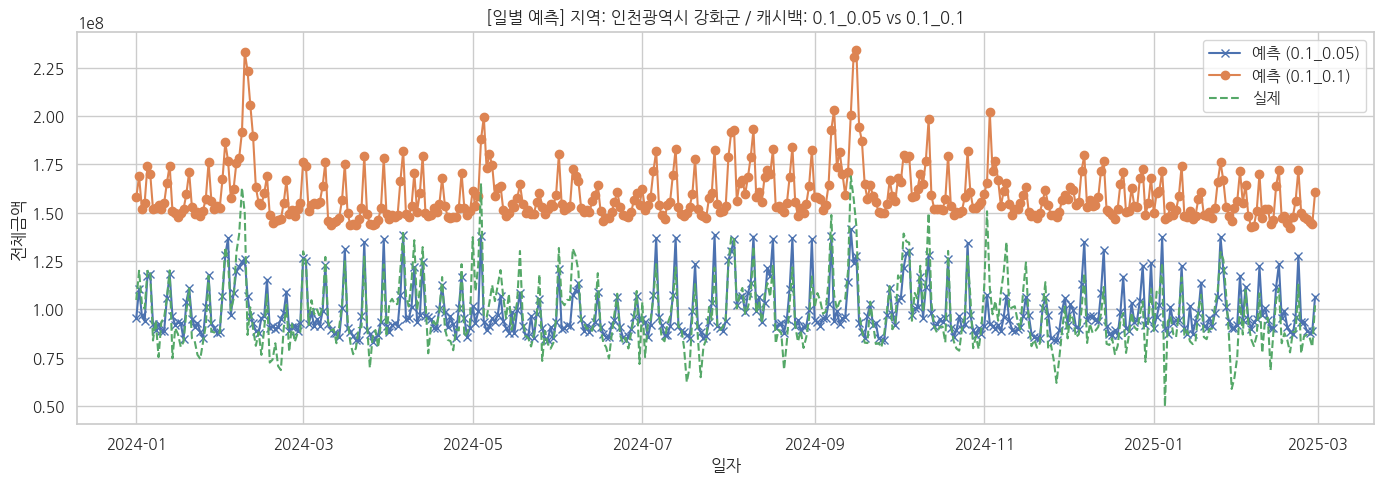

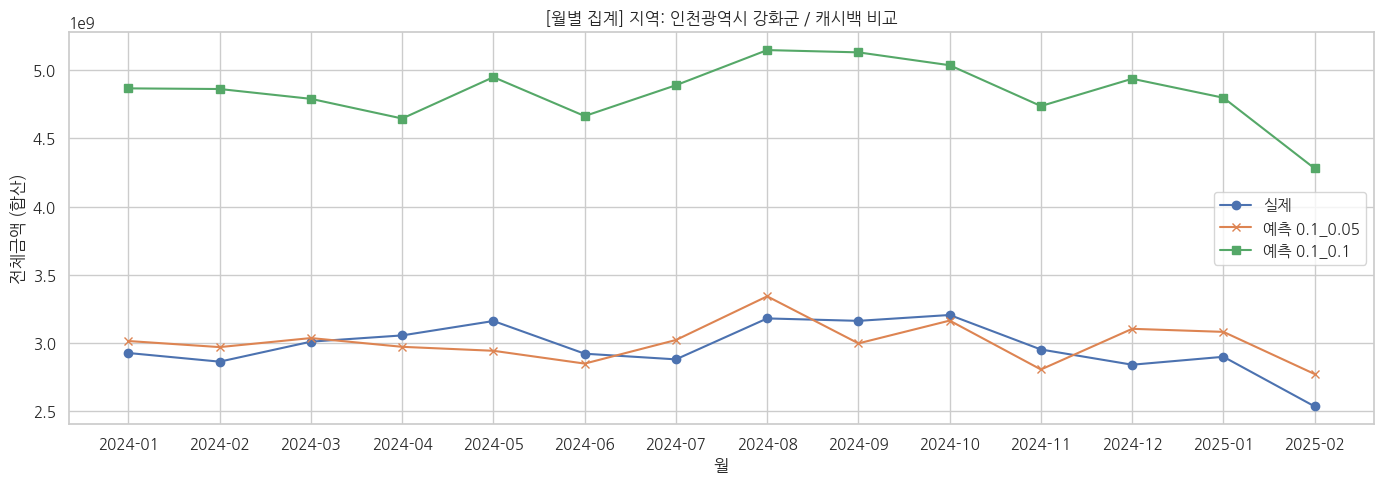


📊 지역: 인천광역시 강화군 - 월별 예측 비교표
          월    예측_0.1_0.1   예측_0.1_0.05            차이
0   2024-01  4.865269e+09  3.014609e+09  1.850660e+09
1   2024-02  4.860557e+09  2.970161e+09  1.890396e+09
2   2024-03  4.788589e+09  3.036354e+09  1.752235e+09
3   2024-04  4.644464e+09  2.972209e+09  1.672256e+09
4   2024-05  4.947599e+09  2.943127e+09  2.004472e+09
5   2024-06  4.662507e+09  2.849309e+09  1.813198e+09
6   2024-07  4.888346e+09  3.022172e+09  1.866174e+09
7   2024-08  5.145683e+09  3.342212e+09  1.803471e+09
8   2024-09  5.129055e+09  2.997437e+09  2.131618e+09
9   2024-10  5.034768e+09  3.164339e+09  1.870429e+09
10  2024-11  4.735746e+09  2.806196e+09  1.929550e+09
11  2024-12  4.935767e+09  3.104103e+09  1.831664e+09
12  2025-01  4.796514e+09  3.081667e+09  1.714847e+09
13  2025-02  4.278474e+09  2.772637e+09  1.505837e+09


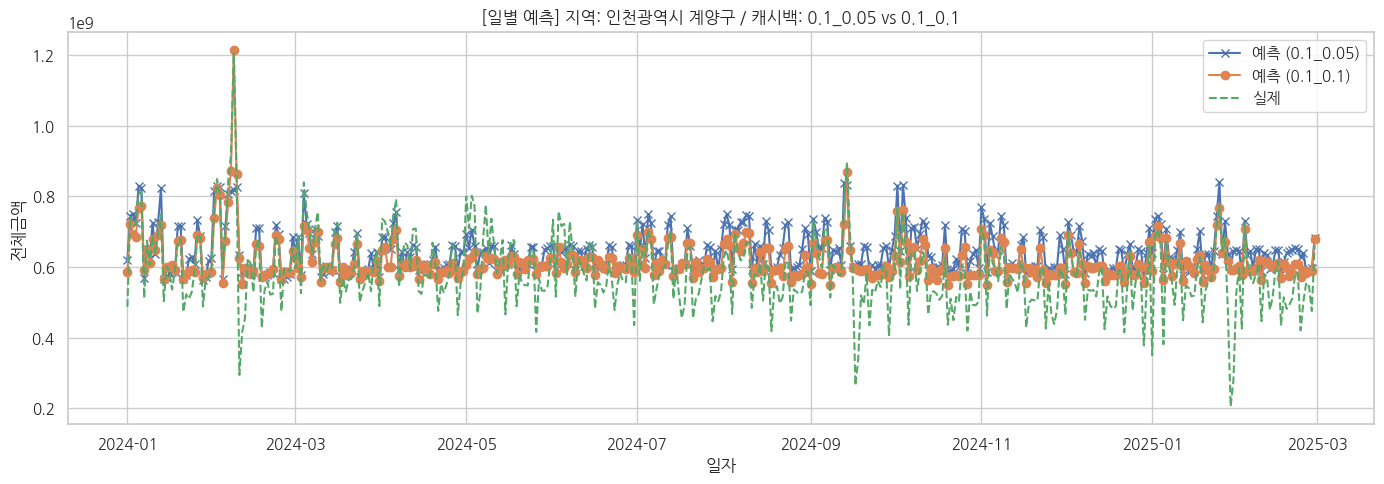

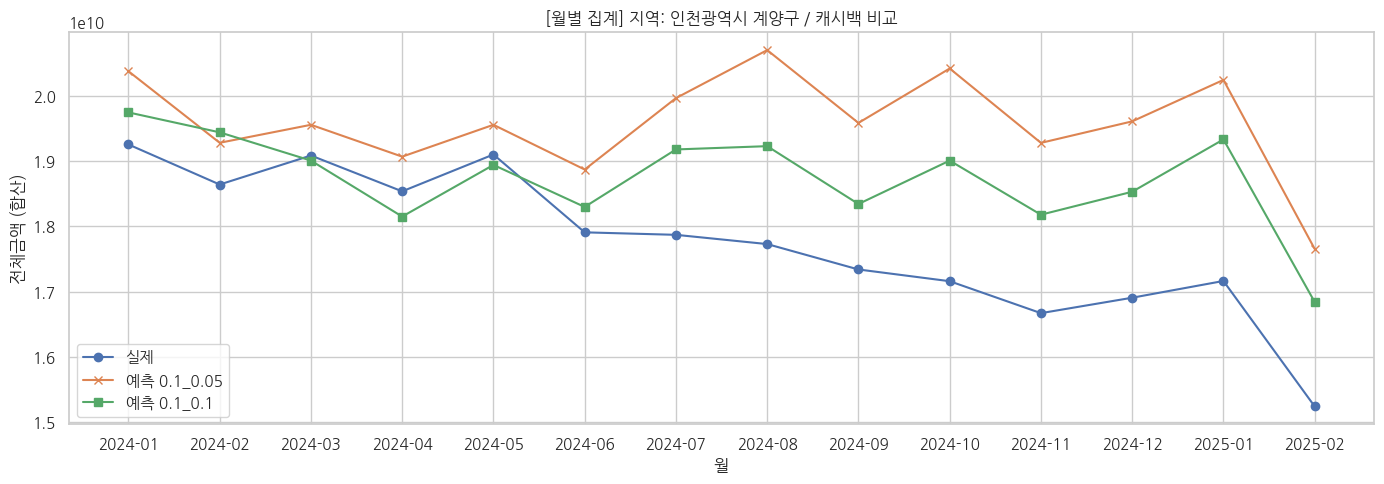


📊 지역: 인천광역시 계양구 - 월별 예측 비교표
          월    예측_0.1_0.1   예측_0.1_0.05            차이
0   2024-01  1.974171e+10  2.037241e+10 -6.306983e+08
1   2024-02  1.943675e+10  1.927674e+10  1.600052e+08
2   2024-03  1.900414e+10  1.955223e+10 -5.480872e+08
3   2024-04  1.814741e+10  1.906468e+10 -9.172701e+08
4   2024-05  1.893811e+10  1.955222e+10 -6.141082e+08
5   2024-06  1.829486e+10  1.886750e+10 -5.726410e+08
6   2024-07  1.917488e+10  1.996060e+10 -7.857189e+08
7   2024-08  1.922516e+10  2.069578e+10 -1.470620e+09
8   2024-09  1.833968e+10  1.958094e+10 -1.241259e+09
9   2024-10  1.900418e+10  2.041396e+10 -1.409787e+09
10  2024-11  1.817601e+10  1.927538e+10 -1.099365e+09
11  2024-12  1.852738e+10  1.960470e+10 -1.077326e+09
12  2025-01  1.932823e+10  2.023910e+10 -9.108665e+08
13  2025-02  1.683971e+10  1.765228e+10 -8.125731e+08


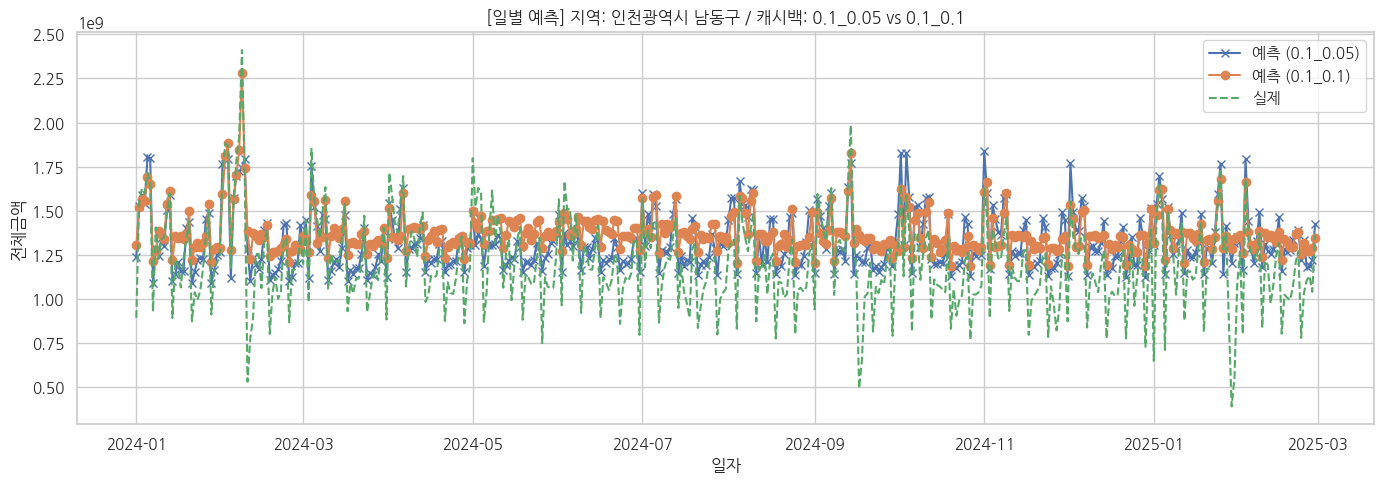

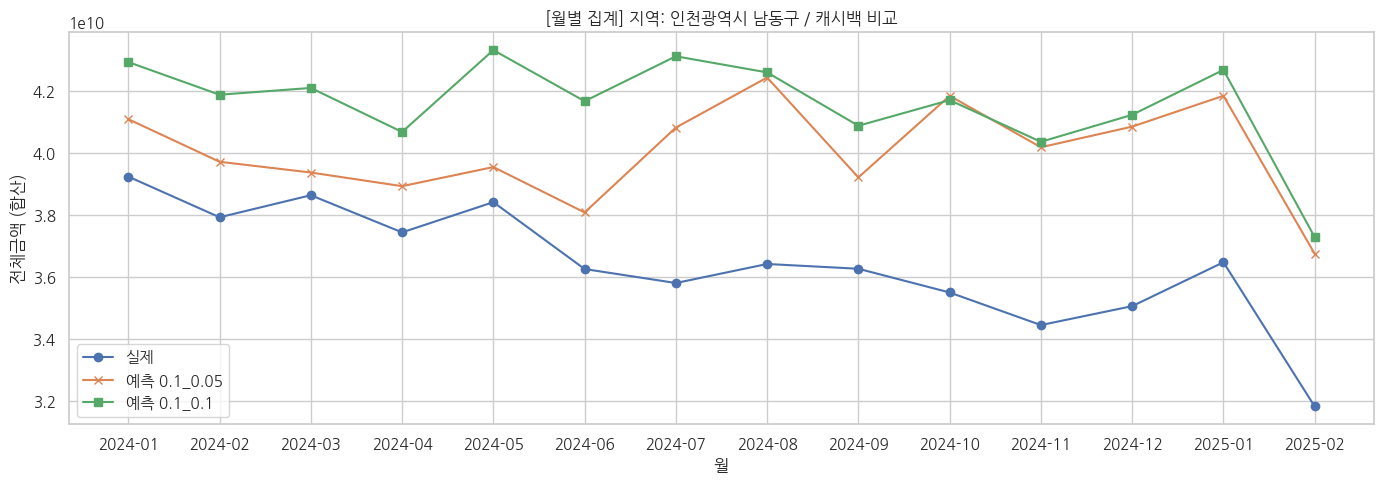


📊 지역: 인천광역시 남동구 - 월별 예측 비교표
          월    예측_0.1_0.1   예측_0.1_0.05            차이
0   2024-01  4.291828e+10  4.108112e+10  1.837157e+09
1   2024-02  4.186817e+10  3.971150e+10  2.156671e+09
2   2024-03  4.208660e+10  3.936543e+10  2.721177e+09
3   2024-04  4.067014e+10  3.892648e+10  1.743662e+09
4   2024-05  4.330416e+10  3.954125e+10  3.762911e+09
5   2024-06  4.166026e+10  3.808069e+10  3.579571e+09
6   2024-07  4.310494e+10  4.081264e+10  2.292305e+09
7   2024-08  4.258596e+10  4.242159e+10  1.643677e+08
8   2024-09  4.087012e+10  3.920876e+10  1.661359e+09
9   2024-10  4.169408e+10  4.183271e+10 -1.386293e+08
10  2024-11  4.035340e+10  4.017828e+10  1.751148e+08
11  2024-12  4.122179e+10  4.084200e+10  3.797921e+08
12  2025-01  4.266642e+10  4.183434e+10  8.320834e+08
13  2025-02  3.728577e+10  3.675144e+10  5.343351e+08


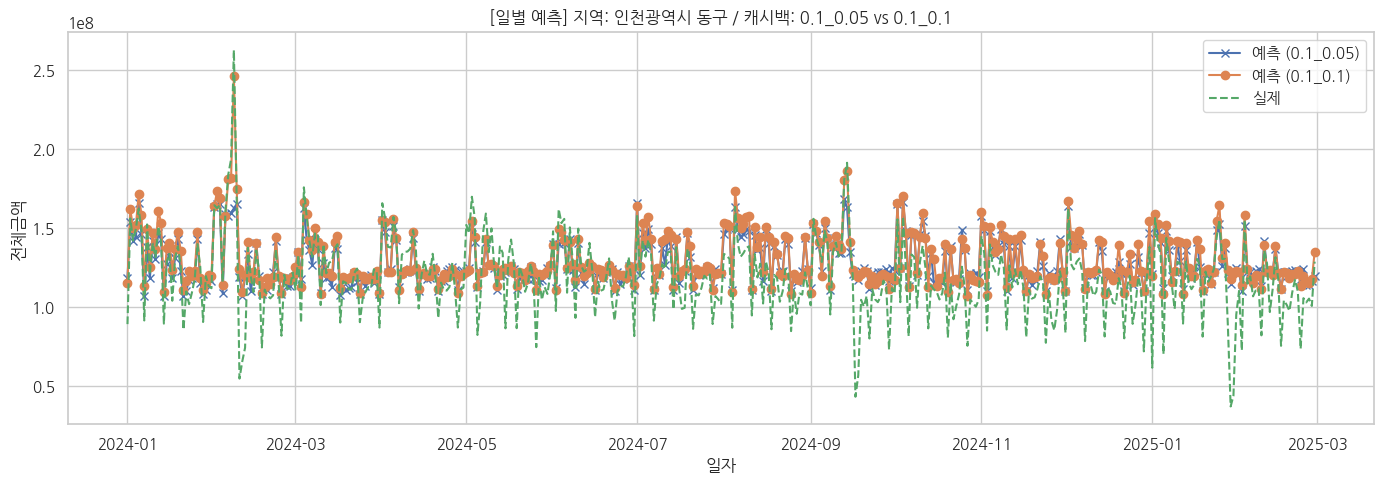

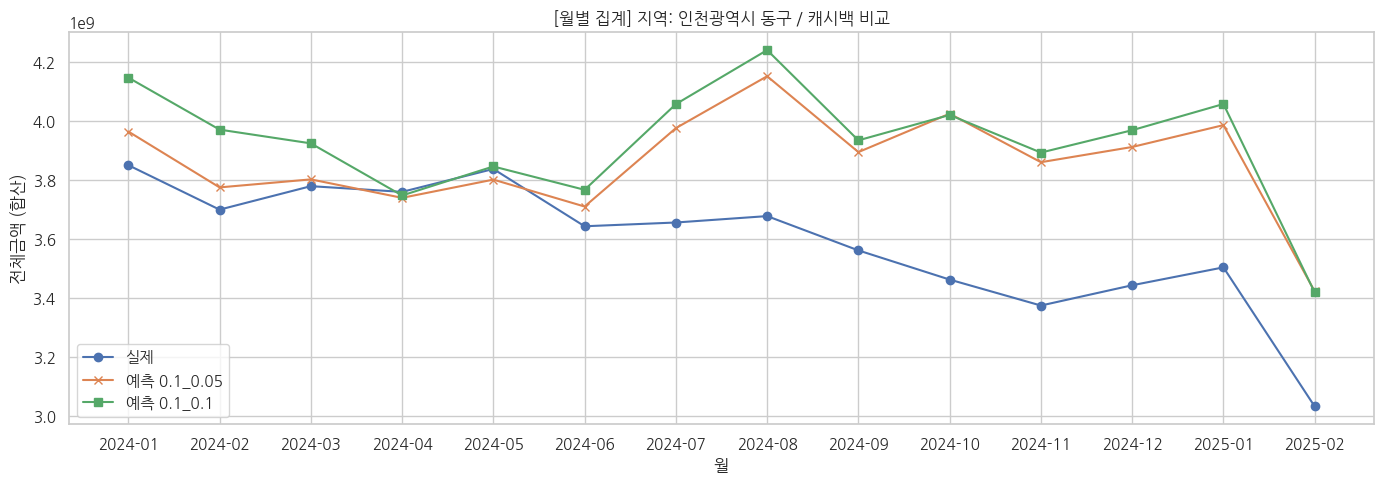


📊 지역: 인천광역시 동구 - 월별 예측 비교표
          월    예측_0.1_0.1   예측_0.1_0.05            차이
0   2024-01  4.148007e+09  3.965282e+09  1.827245e+08
1   2024-02  3.971739e+09  3.775865e+09  1.958738e+08
2   2024-03  3.925142e+09  3.803021e+09  1.221204e+08
3   2024-04  3.748459e+09  3.740462e+09  7.997343e+06
4   2024-05  3.846847e+09  3.802272e+09  4.457564e+07
5   2024-06  3.767668e+09  3.710991e+09  5.667723e+07
6   2024-07  4.058148e+09  3.976787e+09  8.136062e+07
7   2024-08  4.241344e+09  4.152745e+09  8.859928e+07
8   2024-09  3.935358e+09  3.895512e+09  3.984682e+07
9   2024-10  4.021410e+09  4.025742e+09 -4.331948e+06
10  2024-11  3.893877e+09  3.861279e+09  3.259823e+07
11  2024-12  3.969719e+09  3.912852e+09  5.686623e+07
12  2025-01  4.058577e+09  3.986961e+09  7.161664e+07
13  2025-02  3.419934e+09  3.423554e+09 -3.620446e+06


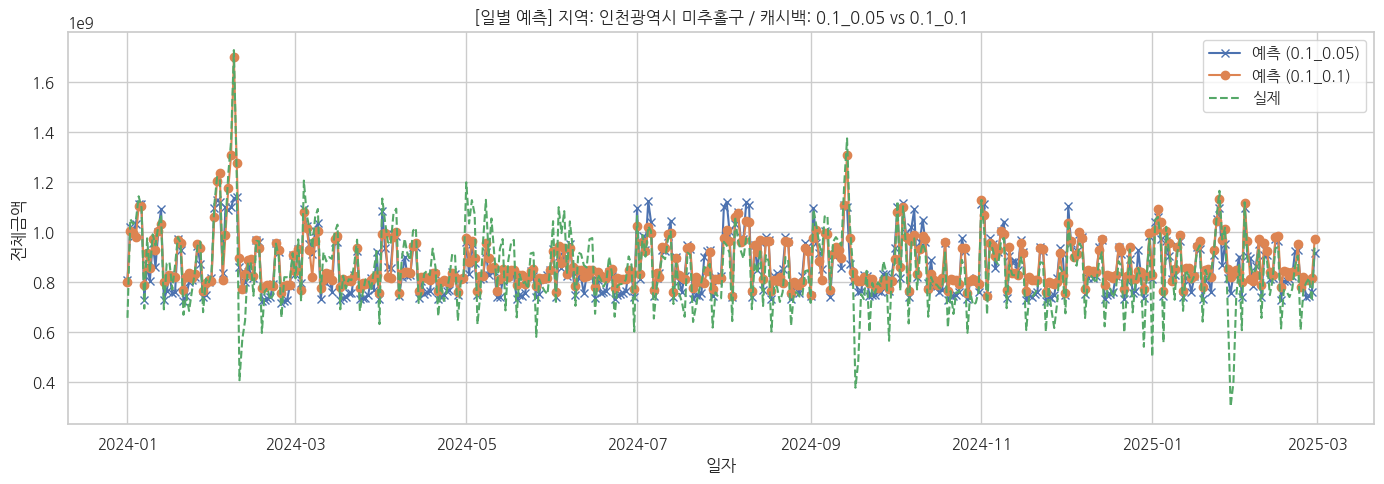

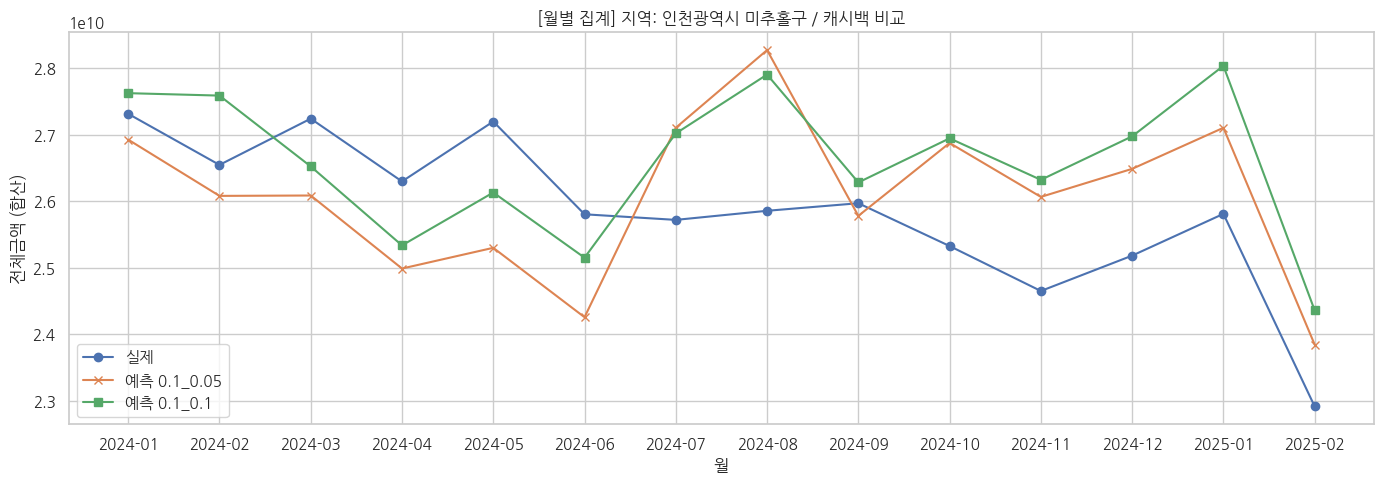


📊 지역: 인천광역시 미추홀구 - 월별 예측 비교표
          월    예측_0.1_0.1   예측_0.1_0.05            차이
0   2024-01  2.762247e+10  2.692458e+10  6.978976e+08
1   2024-02  2.758598e+10  2.607949e+10  1.506493e+09
2   2024-03  2.652193e+10  2.608527e+10  4.366546e+08
3   2024-04  2.533597e+10  2.498809e+10  3.478720e+08
4   2024-05  2.613026e+10  2.529947e+10  8.307808e+08
5   2024-06  2.515121e+10  2.425696e+10  8.942507e+08
6   2024-07  2.701742e+10  2.710306e+10 -8.564240e+07
7   2024-08  2.790186e+10  2.826958e+10 -3.677224e+08
8   2024-09  2.628150e+10  2.577938e+10  5.021215e+08
9   2024-10  2.694415e+10  2.687430e+10  6.985211e+07
10  2024-11  2.632055e+10  2.606415e+10  2.563961e+08
11  2024-12  2.697393e+10  2.648572e+10  4.882115e+08
12  2025-01  2.803284e+10  2.710256e+10  9.302845e+08
13  2025-02  2.436025e+10  2.384566e+10  5.145867e+08


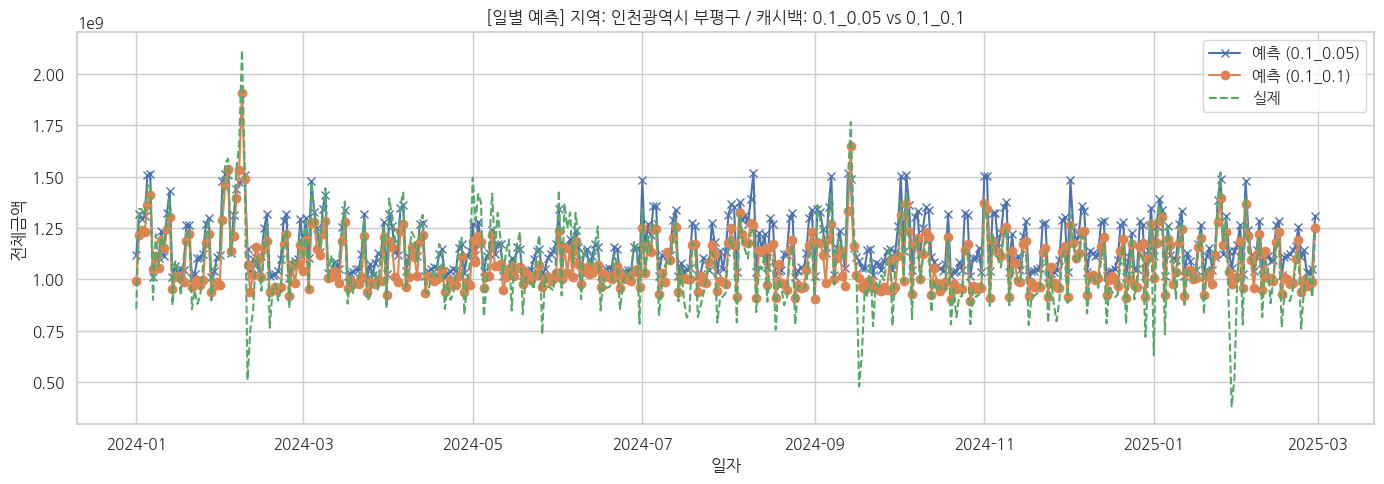

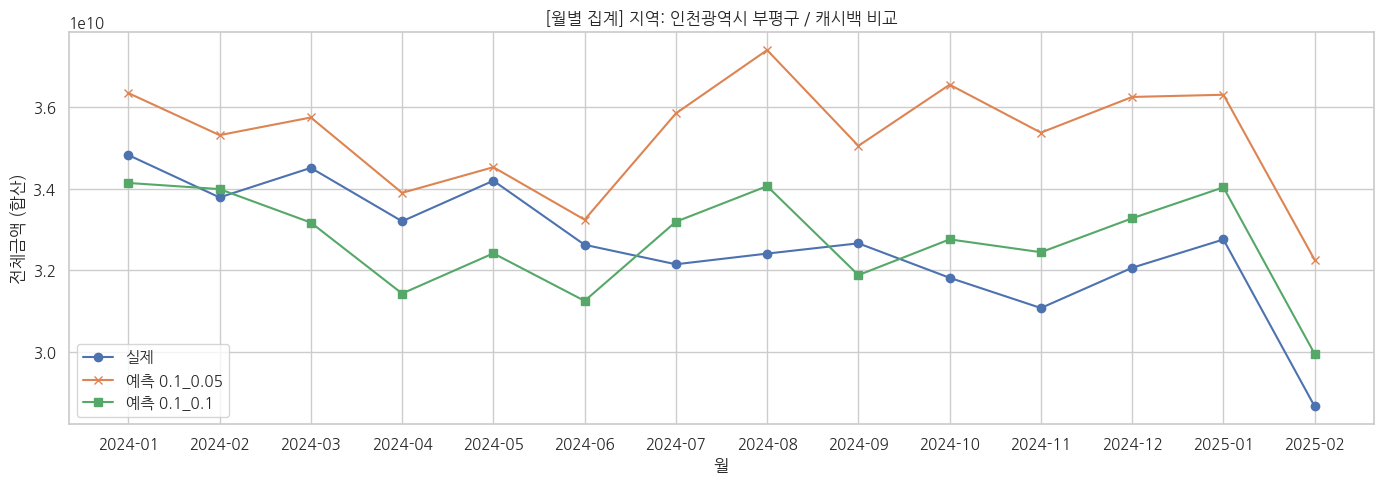


📊 지역: 인천광역시 부평구 - 월별 예측 비교표
          월    예측_0.1_0.1   예측_0.1_0.05            차이
0   2024-01  3.413906e+10  3.634450e+10 -2.205444e+09
1   2024-02  3.398850e+10  3.531219e+10 -1.323688e+09
2   2024-03  3.316727e+10  3.574483e+10 -2.577562e+09
3   2024-04  3.142708e+10  3.389592e+10 -2.468845e+09
4   2024-05  3.241230e+10  3.452589e+10 -2.113591e+09
5   2024-06  3.124631e+10  3.323757e+10 -1.991264e+09
6   2024-07  3.318760e+10  3.584499e+10 -2.657389e+09
7   2024-08  3.406101e+10  3.739804e+10 -3.337025e+09
8   2024-09  3.187881e+10  3.504905e+10 -3.170238e+09
9   2024-10  3.275530e+10  3.654980e+10 -3.794493e+09
10  2024-11  3.244048e+10  3.537328e+10 -2.932804e+09
11  2024-12  3.327242e+10  3.624872e+10 -2.976305e+09
12  2025-01  3.403212e+10  3.630238e+10 -2.270257e+09
13  2025-02  2.994432e+10  3.225138e+10 -2.307060e+09


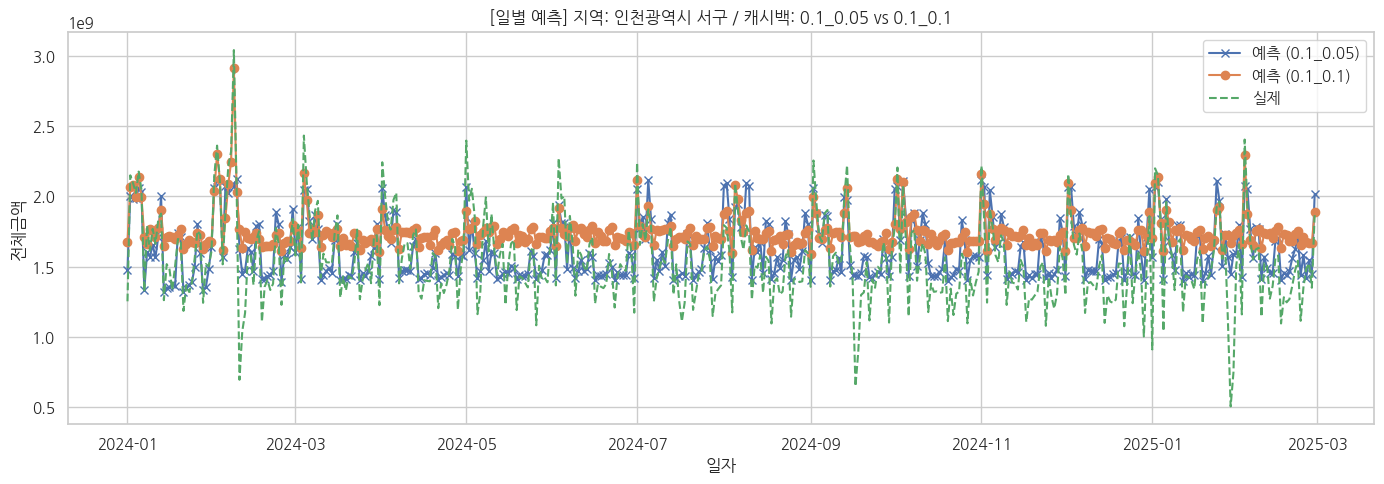

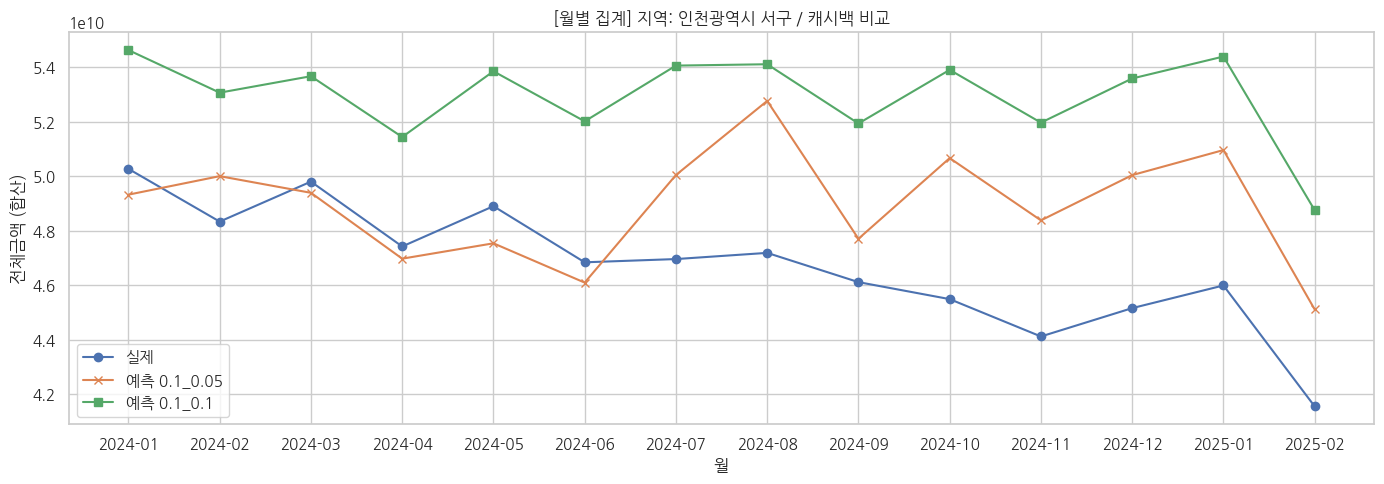

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




📊 지역: 인천광역시 서구 - 월별 예측 비교표
          월    예측_0.1_0.1   예측_0.1_0.05            차이
0   2024-01  5.463363e+10  4.932371e+10  5.309911e+09
1   2024-02  5.306955e+10  5.000302e+10  3.066531e+09
2   2024-03  5.367403e+10  4.939148e+10  4.282548e+09
3   2024-04  5.144111e+10  4.697239e+10  4.468724e+09
4   2024-05  5.385558e+10  4.753666e+10  6.318917e+09
5   2024-06  5.201722e+10  4.609290e+10  5.924321e+09
6   2024-07  5.406395e+10  5.004544e+10  4.018511e+09
7   2024-08  5.411353e+10  5.276670e+10  1.346831e+09
8   2024-09  5.193767e+10  4.770371e+10  4.233962e+09
9   2024-10  5.390733e+10  5.066677e+10  3.240559e+09
10  2024-11  5.196886e+10  4.837917e+10  3.589689e+09
11  2024-12  5.359056e+10  5.004158e+10  3.548984e+09
12  2025-01  5.439687e+10  5.096144e+10  3.435427e+09
13  2025-02  4.875191e+10  4.510722e+10  3.644695e+09
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, se

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-388cfe55cbfa>", line 122, in <cell line: 0>
    plt.tight_layout()
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py", line 2835, in tight_layout
    gcf().tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=rect)
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/figure.py", line 3640, in tight_layout
    engine.execute(self)
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/layout_engine.py", line 183, in execute
    kwargs = get_tight_layout_figure(
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/_tight_layout.py", line 266, in get_tight_layout_figure
    kwargs = _auto_adjust_subplotpars(fig, renderer,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pyt

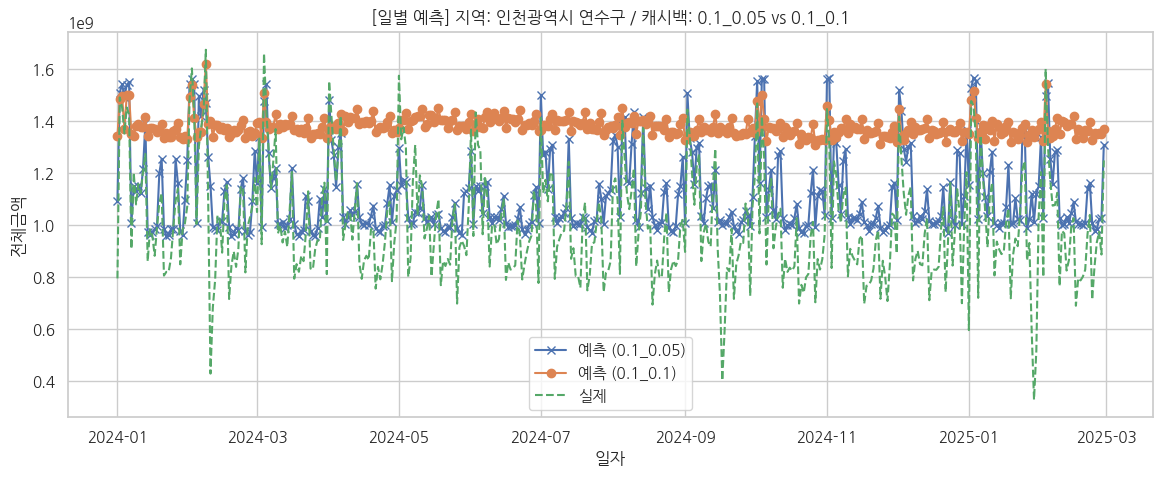

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 데이터 로딩
df = pd.read_csv("인천e음_통합_일별.csv", parse_dates=["일자"])
df = df.sort_values(['지역', '일자'])
df["월"] = df["일자"].dt.to_period("M").astype(str)

# 캐시백 비율 수치형 컬럼 추가
df["캐시백_3억이하"] = df["연매출 3억원 이하"].str.replace("%", "").astype(float) / 100
df["캐시백_3억~30억"] = df["연매출 3억~30억원"].str.replace("%", "").astype(float) / 100
df["캐시백_조합"] = df["캐시백_3억이하"].astype(str) + "_" + df["캐시백_3억~30억"].astype(str)

# 시간 및 정렬
df = df.sort_values(["지역", "일자"])
df["월"] = df["일자"].dt.to_period("M").astype(str)

# lag 변수 생성
for lag in range(1, 30):
    df[f"lpf_trend_shift_{lag}"] = df.groupby("지역")["lpf_trend"].shift(lag)
    df[f"금액_deviation_30_shift_{lag}"] = df.groupby("지역")["금액_deviation_30"].shift(lag)

# 변수 설정
lags = [f"lpf_trend_shift_{lag}" for lag in range(1, 30)] + \
       [f"금액_deviation_30_shift_{lag}" for lag in range(1, 30)]

base_features = [
    "평년_월별_차이", "is_weekend", "is_holiday", "month_sin", "month_cos", "day_sin", "day_cos",
    "연초말_EMT_encoded", "소비자심리지수", "CD수익률", "금리수준전망CSI", "현재생활형편CSI",
    "취업기회전망CSI", "현재가계부채CSI", "남/20_29", "남/30_39", "남/40_49", "남/50_59", "남/총인구수",
    "여/20_29", "여/30_39", "여/40_49", "여/50_59", "여/총인구수", "충전건수", "충전금액", "결제건수",
    "캐시백_3억이하", "캐시백_3억~30억"
]
features = base_features + lags
target = "전체금액"

# LightGBM 하이퍼파라미터
model_params = {
    "n_estimators": 879,
    "learning_rate": 0.006593162865614713,
    "num_leaves": 215,
    "max_depth": 10,
    "min_child_samples": 92,
    "subsample": 0.7186900301226251,
    "colsample_bytree": 0.5586715762310078,
    "reg_alpha": 1.377046983677005e-07,
    "reg_lambda": 1.8694568958308537e-08,
    "random_state": 42
}

# 결과 저장
results = []
monthly_predictions = {}

# 예측할 캐시백 비율
target_cashback = ["0.1_0.05", "0.1_0.1"]
regions = df["지역"].unique()

# 각 비율조합에 대해 지역별로 모델 학습
for cb_ratio in target_cashback:
    df_cb = df[df["캐시백_조합"] == cb_ratio]
    for region in regions:
        df_train = df_cb[(df_cb["지역"] == region) & (df_cb["일자"] < "2024-01-01")]
        df_val = df[(df["지역"] == region) & (df["일자"] >= "2024-01-01")]
        if len(df_train) < 180 or df_val.empty:
            continue

        X_train, y_train = df_train[features], df_train[target]
        X_val = df_val[features]

        model = lgb.LGBMRegressor(**model_params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        df_val_result = df_val.copy()
        df_val_result["예측값"] = y_pred
        df_val_result["비율조합"] = cb_ratio

        key = (region, cb_ratio)
        monthly_predictions[key] = df_val_result

        # 성능 측정
        mae = mean_absolute_error(df_val[target], y_pred)
        rmse = np.sqrt(mean_squared_error(df_val[target], y_pred))
        valid = df_val[target] != 0
        mape = (np.abs((df_val.loc[valid, target] - y_pred[valid]) / df_val.loc[valid, target])).mean() * 100 if valid.sum() > 0 else np.nan

        results.append({
            "비율조합": cb_ratio,
            "지역": region,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape
        })

# 통합 테이블 출력
df_results = pd.DataFrame(results)
print(df_results)

# 시각화 및 월별 집계 비교
for region in regions:
    if (region, "0.1_0.05") in monthly_predictions and (region, "0.1_0.1") in monthly_predictions:
        df_005 = monthly_predictions[(region, "0.1_0.05")].copy()
        df_010 = monthly_predictions[(region, "0.1_0.1")].copy()

        df_005["월"] = df_005["일자"].dt.to_period("M").astype(str)
        df_010["월"] = df_010["일자"].dt.to_period("M").astype(str)

        # 일별 시각화
        plt.figure(figsize=(14, 5))
        plt.plot(df_005["일자"], df_005["예측값"], label="예측 (0.1_0.05)", linestyle="-", marker='x')
        plt.plot(df_010["일자"], df_010["예측값"], label="예측 (0.1_0.1)", linestyle="-", marker='o')
        plt.plot(df_005["일자"], df_005["전체금액"], label="실제", linestyle="--")
        plt.title(f"[일별 예측] 지역: {region} / 캐시백: 0.1_0.05 vs 0.1_0.1")
        plt.xlabel("일자")
        plt.ylabel("전체금액")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 월별 집계 비교
        m005 = df_005.groupby("월")[["전체금액", "예측값"]].sum().rename(columns={"예측값": "예측_0.1_0.05", "전체금액": "실제"})
        m010 = df_010.groupby("월")[["예측값"]].sum().rename(columns={"예측값": "예측_0.1_0.1"})

        df_month_compare = pd.concat([m005, m010], axis=1)
        df_month_compare["차이"] = df_month_compare["예측_0.1_0.1"] - df_month_compare["예측_0.1_0.05"]
        df_month_compare = df_month_compare.reset_index()

        # 월별 시각화
        plt.figure(figsize=(14, 5))
        plt.plot(df_month_compare["월"], df_month_compare["실제"], label="실제", marker='o')
        plt.plot(df_month_compare["월"], df_month_compare["예측_0.1_0.05"], label="예측 0.1_0.05", marker='x')
        plt.plot(df_month_compare["월"], df_month_compare["예측_0.1_0.1"], label="예측 0.1_0.1", marker='s')
        plt.title(f"[월별 집계] 지역: {region} / 캐시백 비교")
        plt.xlabel("월")
        plt.ylabel("전체금액 (합산)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 차이 표 출력
        display_df = df_month_compare[["월", "예측_0.1_0.1", "예측_0.1_0.05", "차이"]]
        print(f"\n지역: {region} - 월별 예측 비교표")
        print(display_df)